In [1]:
!git clone --branch modeling --single-branch https://github.com/alinashev/customer_deposit_prediction_assignment


Cloning into 'customer_deposit_prediction_assignment'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 116 (delta 43), reused 80 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 10.36 MiB | 8.62 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import time
import pandas as pd
import numpy as np
import shap

from hyperopt import hp
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [4]:
from customer_deposit_prediction_assignment.enrich.enricher import PolynomialFeatureEnricher

from customer_deposit_prediction_assignment.models.model.decision_tree_model import DecisionTreeModel
from customer_deposit_prediction_assignment.models.model.logistic_regression_model import LogisticRegressionModel
from customer_deposit_prediction_assignment.models.model.knn_model import KNNModel
from customer_deposit_prediction_assignment.models.model.random_forest import RandomForestModel
from customer_deposit_prediction_assignment.models.model.xgboost_model import XGBModel
from customer_deposit_prediction_assignment.models.model.lgbm_model import LGBMModel
from customer_deposit_prediction_assignment.models.utils.model_error_analyzer import ModelErrorAnalyzer
from customer_deposit_prediction_assignment.models.utils.model_сomparison import ModelComparison

from customer_deposit_prediction_assignment.preprocessing.data_processor import DataProcessor
from customer_deposit_prediction_assignment.preprocessing.processor import Processor
from customer_deposit_prediction_assignment.preprocessing.utils.utils import define_numerical_cols

from customer_deposit_prediction_assignment.resampling.smotenc_resampler import SmotencResampler

from customer_deposit_prediction_assignment.tuning.randomized_search_tuner import RandomSearchTuner
from customer_deposit_prediction_assignment.tuning.hyperopt_tuner import HyperoptTuner

from customer_deposit_prediction_assignment.utils.class_dist_visualizer import ClassDistributionVisualizer

%load_ext autoreload
%autoreload 2

## Preprocessing

In [5]:
df_init = pd.read_csv("customer_deposit_prediction_assignment/data/bank-additional-full.csv", sep=';')
df = df_init.copy()

In [6]:
processor = Processor(target_col="y", unnecessary_columns=["duration"], scaling_method="standard")
data_processor = DataProcessor(
    processor=processor,
    apply_outliers_processing=True,
    apply_feature_engineering=True
)

X_train, y_train, X_val, y_val = data_processor.process(df)

In [7]:
display(X_train.head(1)), display(X_val.head(1))

age  education  contact  month  day_of_week  campaign  previous  \
25611  0.89007        3.0        1     11            3  1.174958 -0.376437   

       emp.var.rate  cons.price.idx  cons.conf.idx  ...  marital_single  \
25611     -0.114858       -0.648967      -0.324914  ...             0.0   

       housing_no  housing_yes  loan_no  loan_yes  default_no  default_yes  \
25611         1.0          0.0      1.0       0.0         0.0          0.0   

       poutcome_failure  poutcome_nonexistent  poutcome_success  
25611               0.0                   1.0               0.0  

[1 rows x 48 columns]

age  education  contact  month  day_of_week  campaign  previous  \
14455 -0.78599        6.0        1      7            2  1.594231 -0.376437   

       emp.var.rate  cons.price.idx  cons.conf.idx  ...  marital_single  \
14455        0.8398        0.590675      -0.476655  ...             0.0   

       housing_no  housing_yes  loan_no  loan_yes  default_no  default_yes  \
14455         1.0          0.0      1.0       0.0         1.0          0.0   

       poutcome_failure  poutcome_nonexistent  poutcome_success  
14455               0.0                   1.0               0.0  

[1 rows x 48 columns]

(None, None)

## Resampling

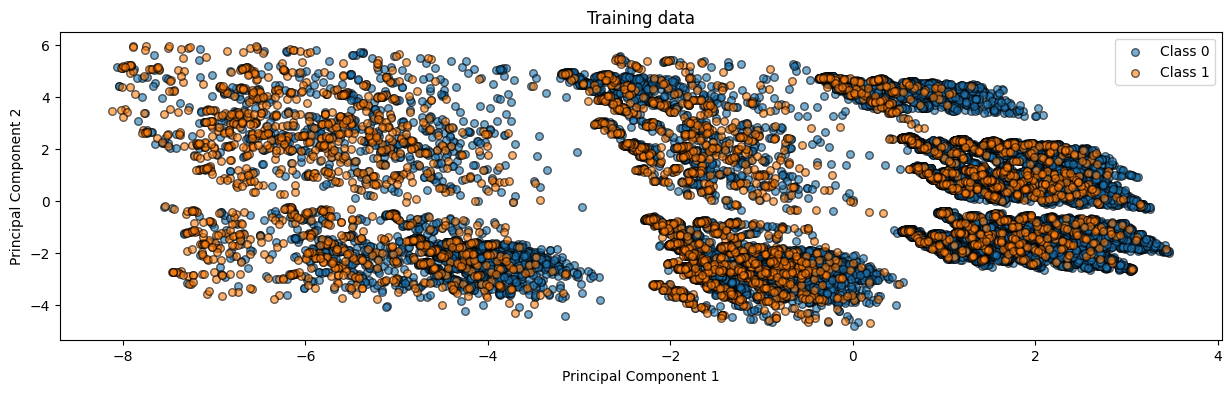

y
0    29238
1     3712
Name: count, dtype: int64


In [8]:
dist_visualizer = ClassDistributionVisualizer(df['y'])
dist_visualizer.plot_data_with_pca(X_train, y_train, title="Training data")

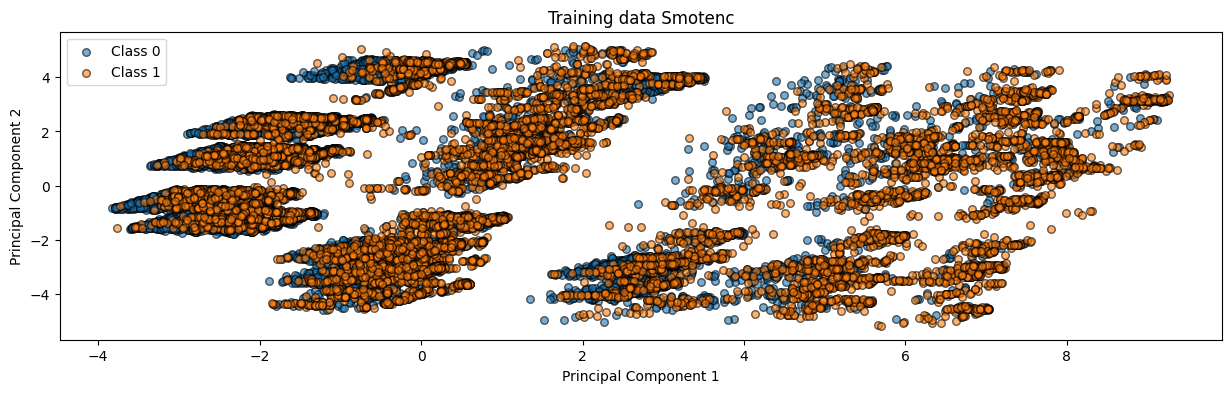

y
0    29238
1    14619
Name: count, dtype: int64


In [9]:
encoded_indices = processor.get_encoded_feature_indices(define_numerical_cols(df))

smotenc_resampler = SmotencResampler(categorical_features=encoded_indices)

X_t_resampled_smotenc, y_t_resampled_smotenc = smotenc_resampler.fit_resample(X_train, y_train)
dist_visualizer.plot_data_with_pca(X_t_resampled_smotenc, y_t_resampled_smotenc, title="Training data Smotenc")

## Modelling

In [10]:
model_comparator = ModelComparison()

def evaluate_model(model, note):
    model_comparator.add_model(model, note)
    model.display_confusion_matrix()
    model.display_roc_auc()
    model_comparator.display_metrics(model.compute_all_metrics())

### LogisticRegressionModel

#### Baseline model

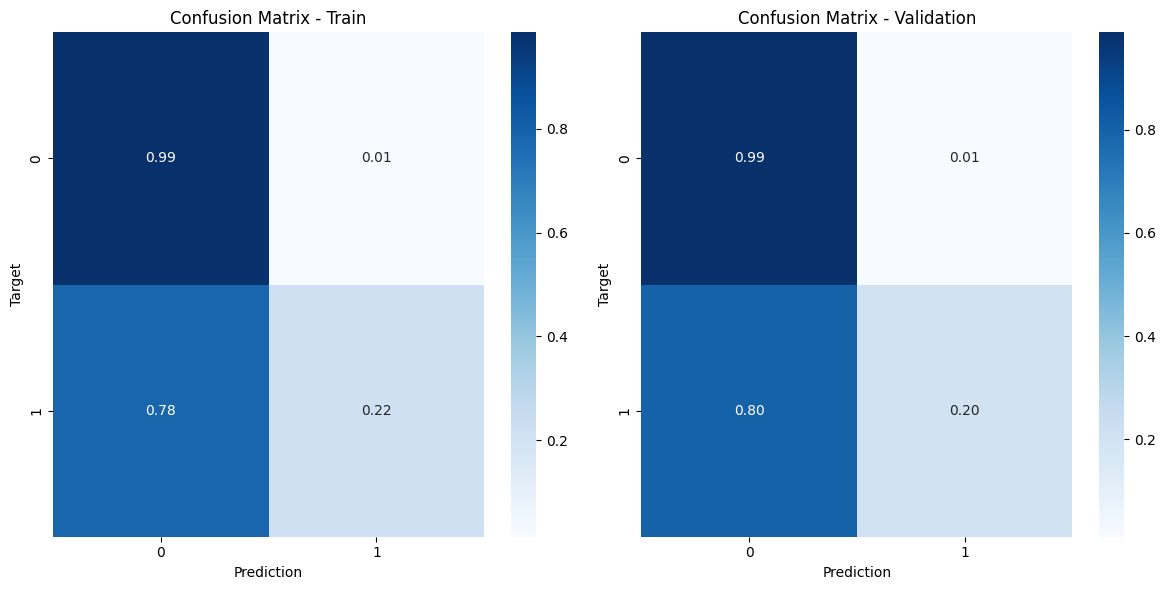

AUROC for Train dataset: 0.7864
AUROC for Validation dataset: 0.7993


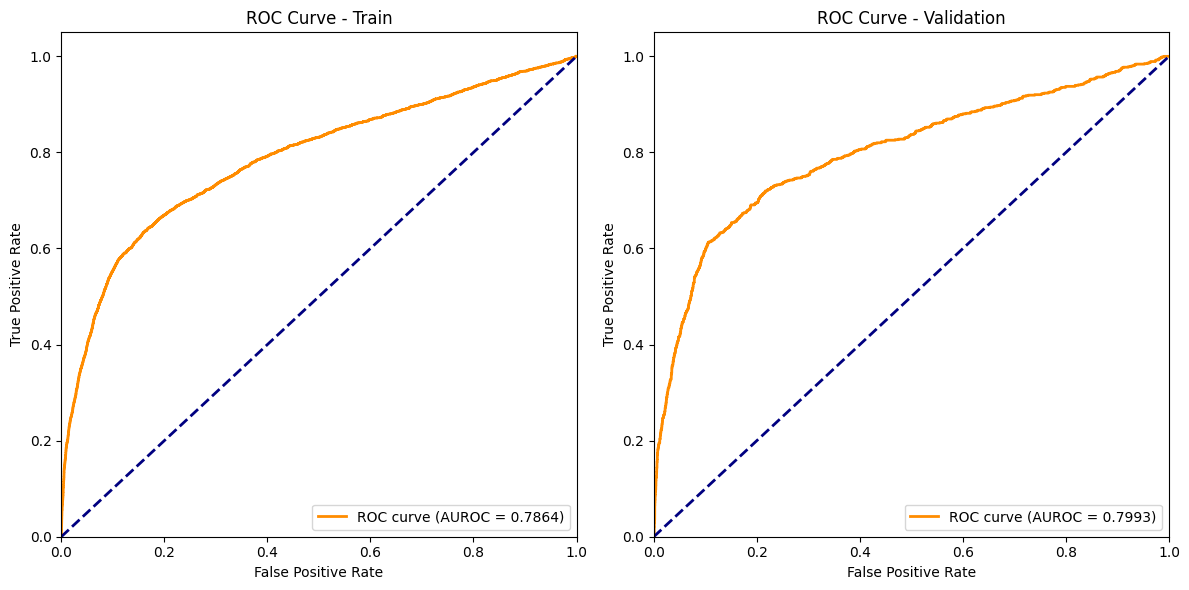

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3273 │           0.3117 │
│ roc_auc  │      0.7864 │           0.7993 │
└──────────┴─────────────┴──────────────────┘

In [11]:
log_model = LogisticRegressionModel(X_train, y_train, X_val, y_val).fit().predict()
evaluate_model(log_model, "Baseline model.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки (TN): 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Багато False Negative (FN): модель пропускає 78% (80% на валідаційному наборі) клієнтів.
- Дуже низьке TP (True Positives) – всього 22%: модель майже не передбачає тих, хто справді уклав строковий депозит.
- Бачимо, що результати метрики roc_auc на тренувальній та валідаційній вибірках подібні. Перенавчання не спостерігається.
- Модель не ідеально розрізняє клієнтів, які підпишуть строковий депозит, і тих, які відмовляться.
- F1-score (≈ 0.31) є досить низьким, що вказує на слабку здатність моделі правильно ідентифікувати позитивний клас.
- Модель має дуже високу асиметрію класів: вона переважно передбачає "Ні", а "Так" майже не визначає.
- Основна проблема – модель ігнорує позитивний клас.


In [12]:
model_comparator.update_model_comment(log_model,
                                      "Посередня модель. Слабкий recall для класу 1, F1 = 0.31. Базова модель для порівняння.")

#### LogRegression with polynomial features

Додамо до моделі логістичної регресії поліноміальні ознаки.

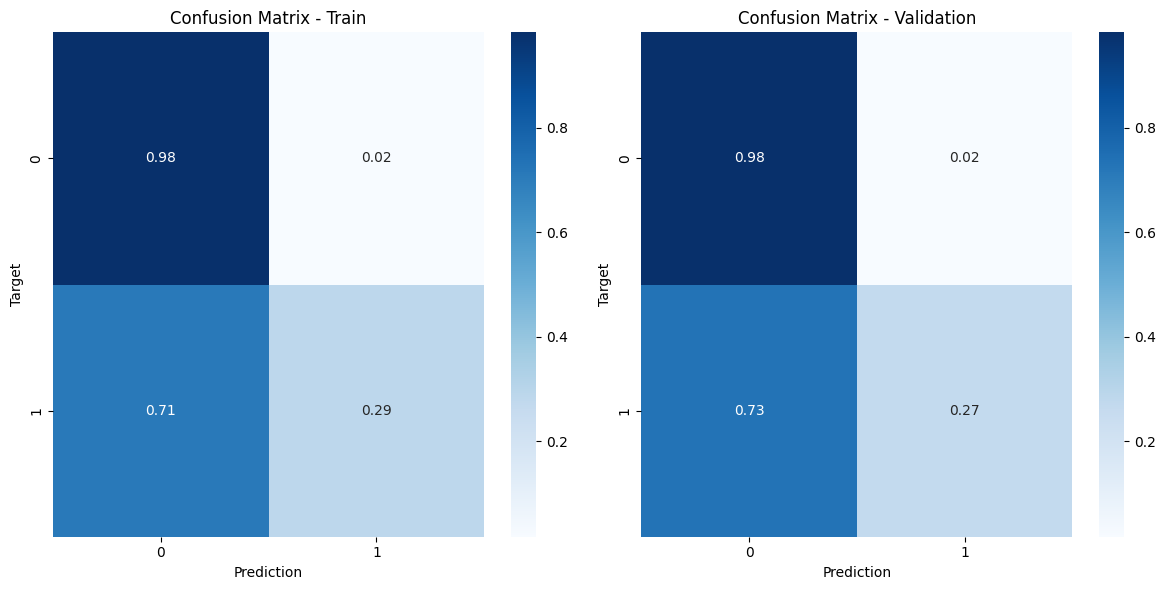

AUROC for Train dataset: 0.8163
AUROC for Validation dataset: 0.7964


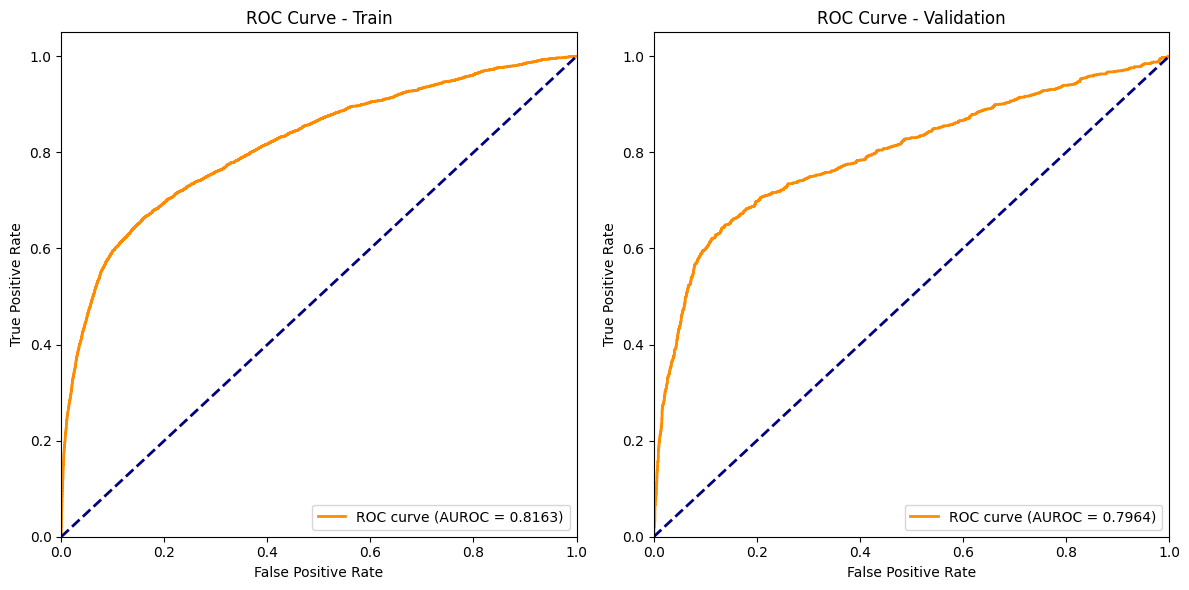

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4028 │           0.3840 │
│ roc_auc  │      0.8163 │           0.7964 │
└──────────┴─────────────┴──────────────────┘

In [13]:
model_log_pol_2 = LogisticRegressionModel(X_train, y_train, X_val, y_val,
                                          enricher=PolynomialFeatureEnricher(degree=2)).fit().predict()
evaluate_model(model_log_pol_2, "Added polynomial features.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Багато False Negative (FN): 71% (73% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- Низьке TP (True Positives) – майже 30% - є правильними передбаченнями значення "Так": модель майже не передбачає тих, хто справді уклав строковий депозит, хоча вже показник покращився порівняно з минулою моделлю.
- Значення метрики roc_auc залишається на рівні попередньої моделі (без додавання поліноміальних ознак), що свідчить про схожу здатність моделі розділяти класи.
- Бачимо, що значення метрики на тренувальній вибірці вище за валідаційну, ймовірно присутнє перенавчання.
- F1-score значно покращився відносно попередньої моделі, що означає кращий баланс між Precision та Recall. і що модель краще знаходить клієнтів, які підпишуться.
- Модель виявляє більше позитивних випадків (менше False Negatives), що вже є покращенням.
- Модель все ще надає перевагу класу "Ні".
- Результати метрик показують про можливе наявне невелике перенавчання моделі через додавання поліноміальних ознак.

In [14]:
model_comparator.update_model_comment(model_log_pol_2,
                                      "Посередня модель. Поліноміальні ознаки незначно покращили AUC, але F1 залишився слабким (0.38).")

#### LogRegression with resampling

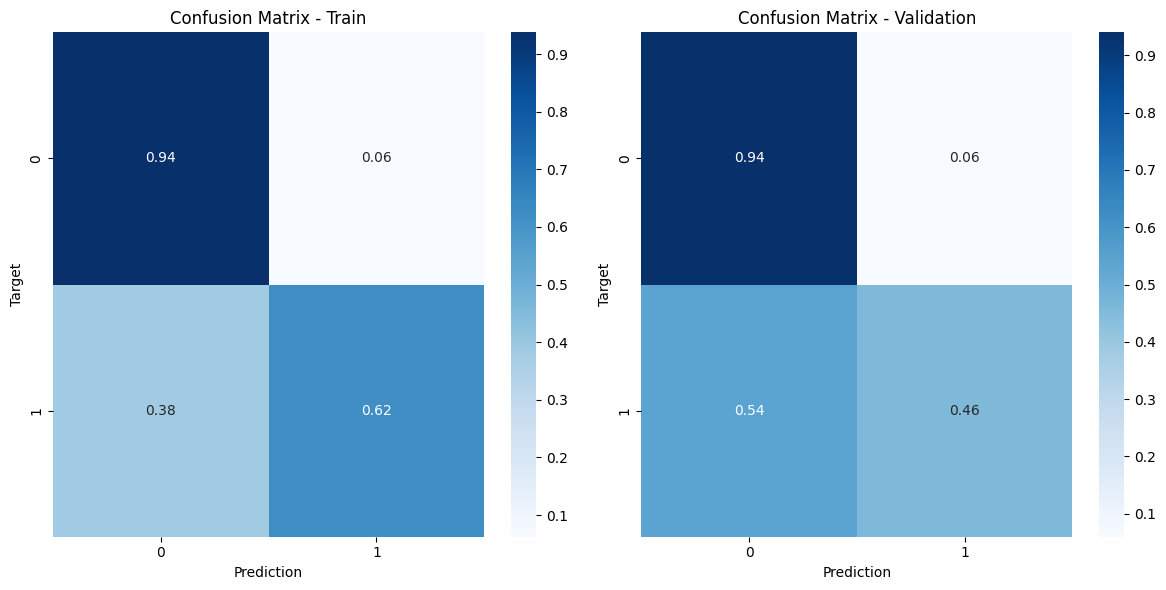

AUROC for Train dataset: 0.8648
AUROC for Validation dataset: 0.7898


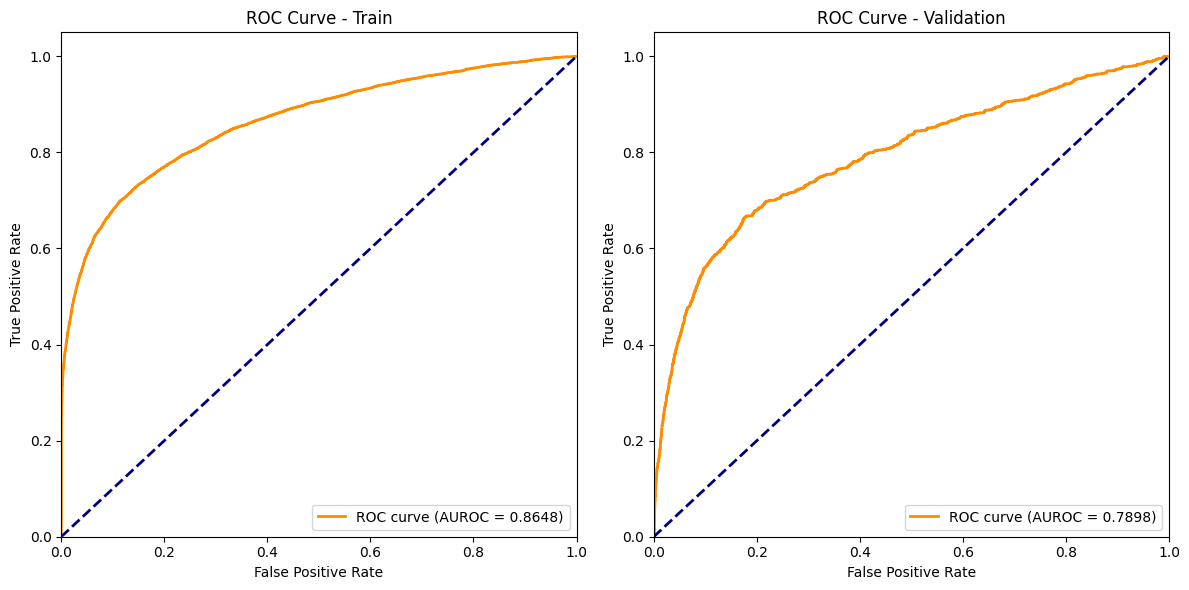

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7104 │           0.4735 │
│ roc_auc  │      0.8648 │           0.7898 │
└──────────┴─────────────┴──────────────────┘

In [15]:
log_model_rs = LogisticRegressionModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, ).fit().predict()
evaluate_model(log_model_rs, "With data resampling.")

**Спостереження**:

- Висока точність (TPR ≈ 86.7%) для класу 0 → модель добре визначає "негативні" приклади.
- Точність для класу 1 значно покращилася (TPR ≈ 58.4% на валідації) → суттєво краще, ніж у попередніх моделях.
- Перенавчання: AUC (Train: 0.8817, Val: 0.7787) → модель добре працює на тренуванні, але якість значно падає на валідації.
- F1-score: 0.79 (Train) → 0.45 (Validation) → високий F1 на тренуванні, але значне падіння на валідації, що вказує на перенавчання.
- Ресемплінг суттєво покращує здатність виявляти позитивний клас, але призводить до перенавчання.
- AUC на валідації (~0.78) навіть нижчий, ніж у моделі з поліноміальними ознаками.

In [16]:
model_comparator.update_model_comment(log_model_rs,
                                      "Посередня модель. Ресемплінг значно покращив TPR для класу 1, але викликав сильне перенавчання (F1 впав з 0.79 до 0.45).")

### kNN

Натренуємо декілька моделей kNN.

#### Модель kNN (k=3, 5, 10)

k=3


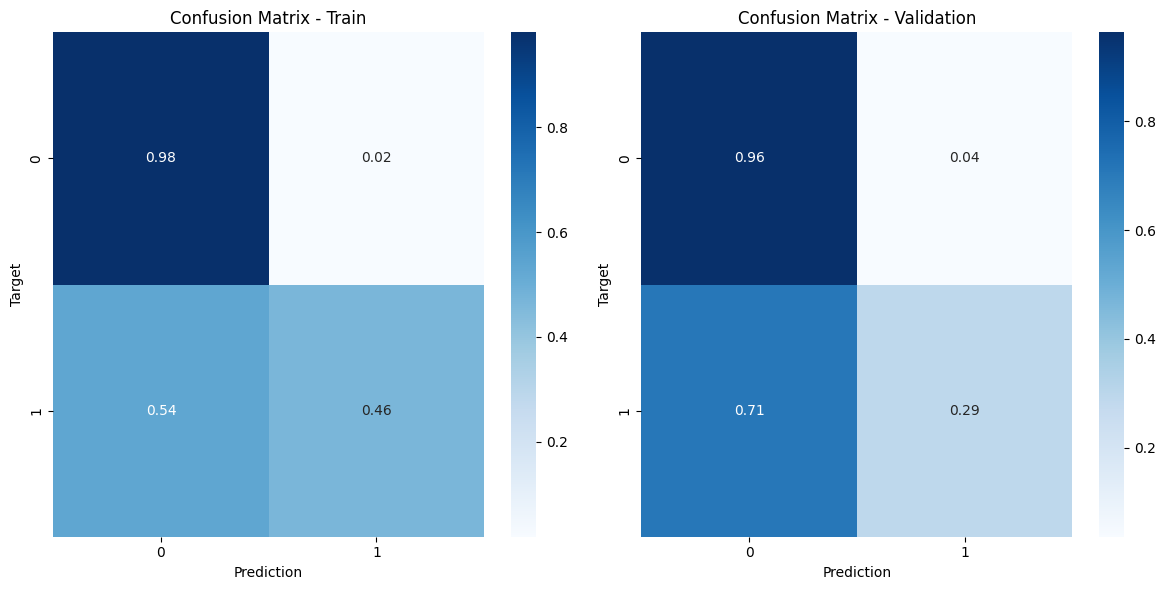

AUROC for Train dataset: 0.9510
AUROC for Validation dataset: 0.7098


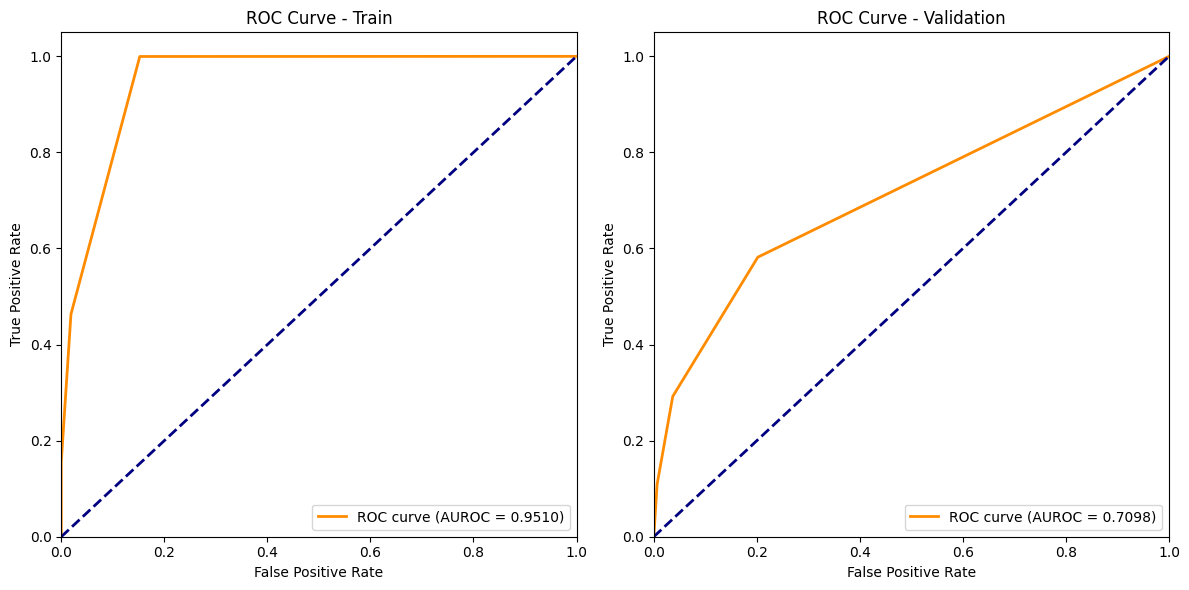

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.5749 │           0.3692 │
│ roc_auc  │      0.9510 │           0.7098 │
└──────────┴─────────────┴──────────────────┘

k=5


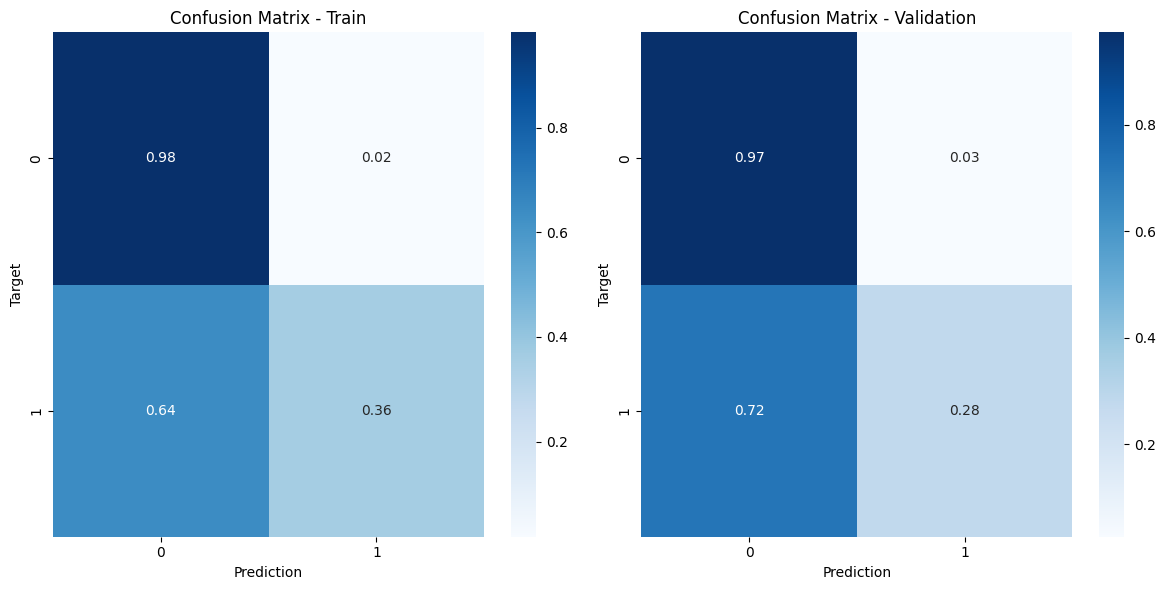

AUROC for Train dataset: 0.9245
AUROC for Validation dataset: 0.7332


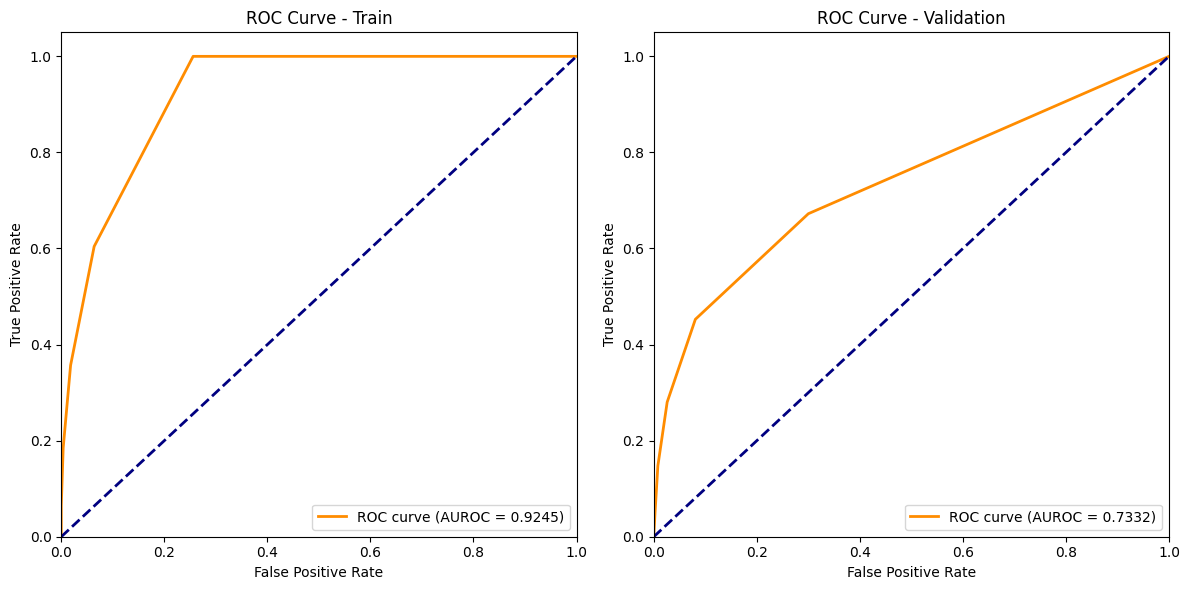

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4761 │           0.3774 │
│ roc_auc  │      0.9245 │           0.7332 │
└──────────┴─────────────┴──────────────────┘

k=10


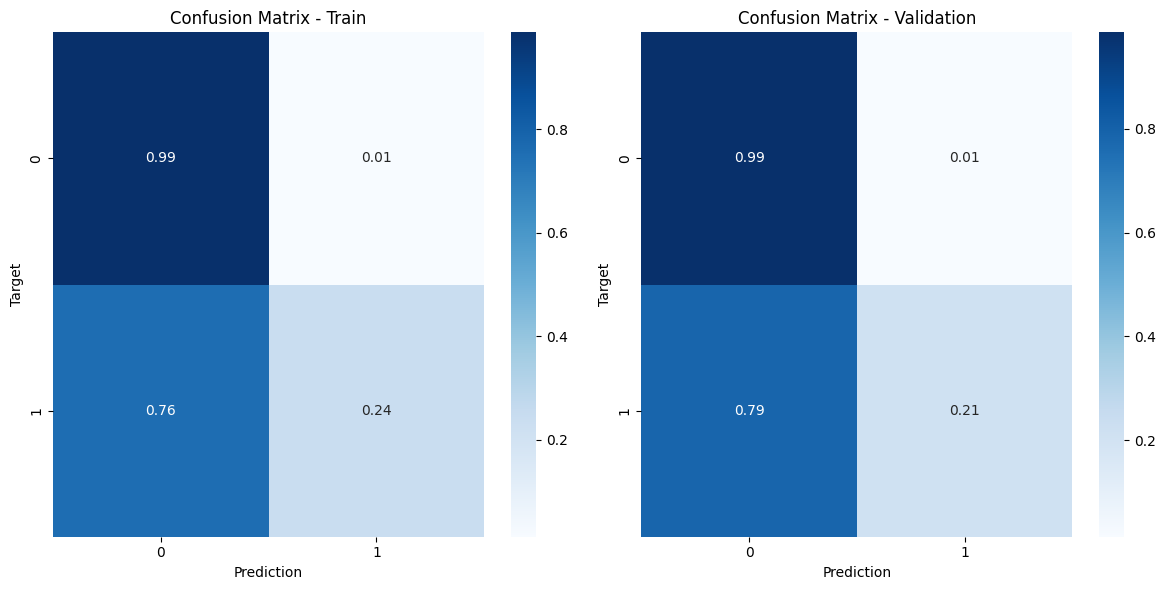

AUROC for Train dataset: 0.8877
AUROC for Validation dataset: 0.7550


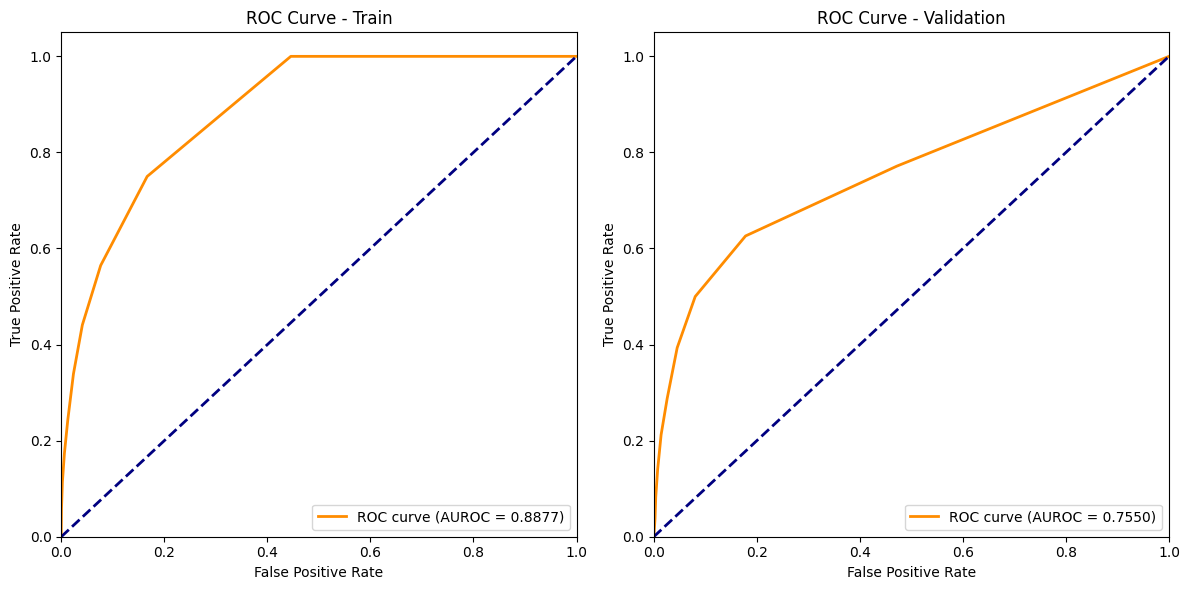

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3612 │           0.3206 │
│ roc_auc  │      0.8877 │           0.7550 │
└──────────┴─────────────┴──────────────────┘

In [17]:
K = [3, 5, 10]
knn_models = {}

for k in K:
    knn_model = KNNModel(X_train, y_train, X_val, y_val, n_neighbors=k).fit().predict()
    print(f"k={k}")
    model_comparator.add_model(knn_model, f"kNN k={k}")
    knn_model.display_confusion_matrix()
    knn_model.display_roc_auc()
    model_comparator.display_metrics(knn_model.compute_all_metrics())

    knn_models[k] = knn_model

**Загальні спостереження про моделі**:

k=3:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (та 4% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків 54% (70% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує майже половину позитивних значень, але на валідації показник падає до 29%, що свідчить про перенавчання.
- Бачимо великий розрив між значеннями метрики для тренувального та валідаційного наборів даних.
- Можемо говорити про явно виражене перенавчання.
- AUROC на тренувальній вибірці дуже високий, а на валідаційній стрімко падає.
-  F1-score значно зменшується, що підтверджує сильне перенавчання.
- Загалом модель на тренувальних даних показує хороший результат, але гірше працює на нових даних.
- Модель дуже добре розпізнає клас "Ні", але гірше справляється з класом "Так"

k=5:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (та 3% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків 63% (72% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 36% позитивних значень, але на валідації показник падає до 28%. Точність передбачення підписки покращилася у порівнянні з k=3, але все ще низька.
- Бачимо, що різниця значень AUROC метрики для тренувального та валідаційного наборів вже знизилась, порівняно з k=3, але все ще маємо достатньо великий розрив. Що говорить нам про перенавчання моделі.
- AUROC на тренувальній вибірці дуже високий, а на валідаційній набагато нижче.
- Різниця між значеннями AUROC зменшилась порівняно з k=3, що вказує на менше перенавчання.
- F1-score став більш стабільним, але твсе ще вказує на перенавчанння.
- Загалом модель на тренувальних даних показує гарний результат, але гірше працює на нових даних.
- Все ще сильний перекіс у передбаченнях – модель краще розпізнає "Ні", ніж "Так".

k=10:

- Модель дуже добре передбачає негативні випадки: 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав. Отже маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 76% (79% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 26% позитивних значень, але на валідації показник падає до 21%. Точність передбачення підписки все ще низька.
- Бачимо, що розрив значень метрики зменшилась у порівнянні з k=5 та k=3. Можемо говорити. що рівень перенавчання зменшилось.
- AUROC на тренувальній вибірці високий, коли на валідаційній набагато нижче.
- Різниця між значеннями AUROC зменшилась порівняно з k=3 та з k=5, що вказує на менше перенавчання.
- F1-score погіршився у порівнянні з k=5, що означає ще більший розрив між передбаченням та реальними даними.
- Загалом модель на тренувальних даних показує гарний результат, але гірше працює на нових даних.
- Все ще сильний перекіс у передбаченнях – модель краще розпізнає "Ні", ніж "Так".

**Загальні спостереження про модельювання за допомогою kNN на оригінальних даних без ресамплінгу**

Проведено моделювання за допомогою kNN з різними значеннями k (3, 5, 10). Можемо зробити наступні висновки:

- Чим менше k (k=3), тим сильніше перенавчання, отже модель ідеально запам’ятовує тренувальні дані, але погано працює на нових даних.
- Чим більше k (k=10), тим менше перенавчання, але все ще погано визначає позитивний клас.
- Модель значно краще передбачає клас "Ні", ніж "Так" → recall для класу "Так" залишається низьким.
- kNN не є ефективним для нашої задачі, особливо в передбаченні позитивного класу.
- Навіть при збільшенні k результати не сильно покращуються, перенавчання зменшується, але результати не наближаються до рівня логістичної регресії.


In [18]:
model_comparator.update_model_comment(knn_models[3],
                                      "Посередня модель. Високий AUC (0.95) на train, але значне падіння (0.71) на валідації. F1 слабкий (0.37). k=3 занадто мале.")
model_comparator.update_model_comment(knn_models[5],
                                      "Посередня модель. AUC впав з 0.92 (train) до 0.73 (val). F1 слабкий (0.38). k=5 трохи покращує ситуацію, але не вирішує проблему.")
model_comparator.update_model_comment(knn_models[10],
                                      "Посередня модель. Менше перенавчання, але слабкий F1 (0.32). AUC зріс до 0.75, але модель все ще погано розпізнає позитивний клас.")

#### Модель kNN з ресамплінгом (k=3, 5, 10)

k=3


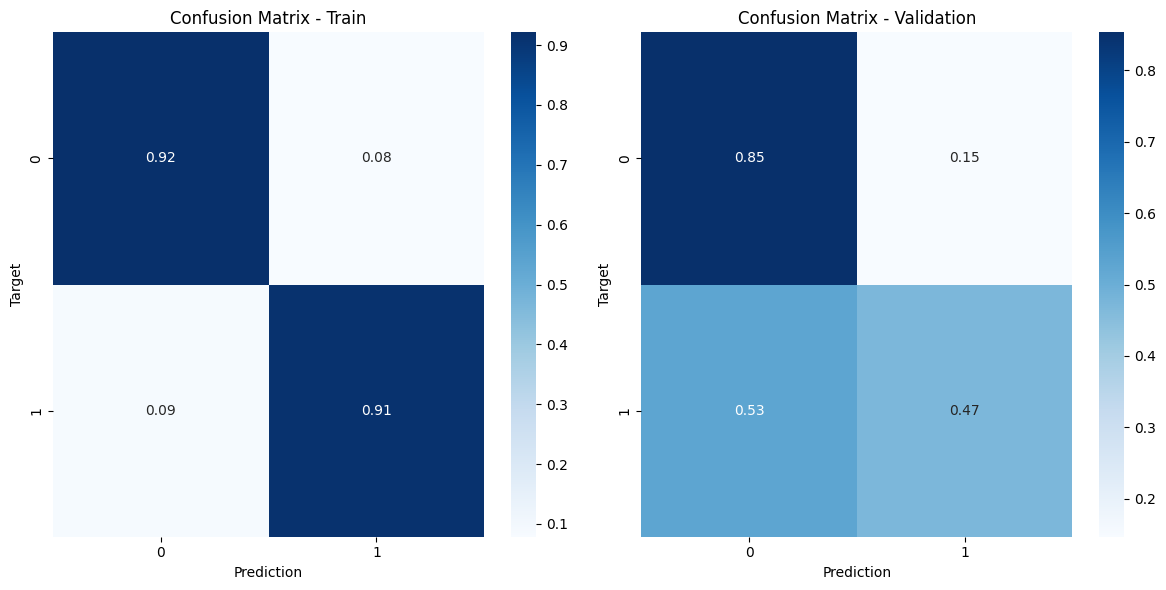

AUROC for Train dataset: 0.9800
AUROC for Validation dataset: 0.7058


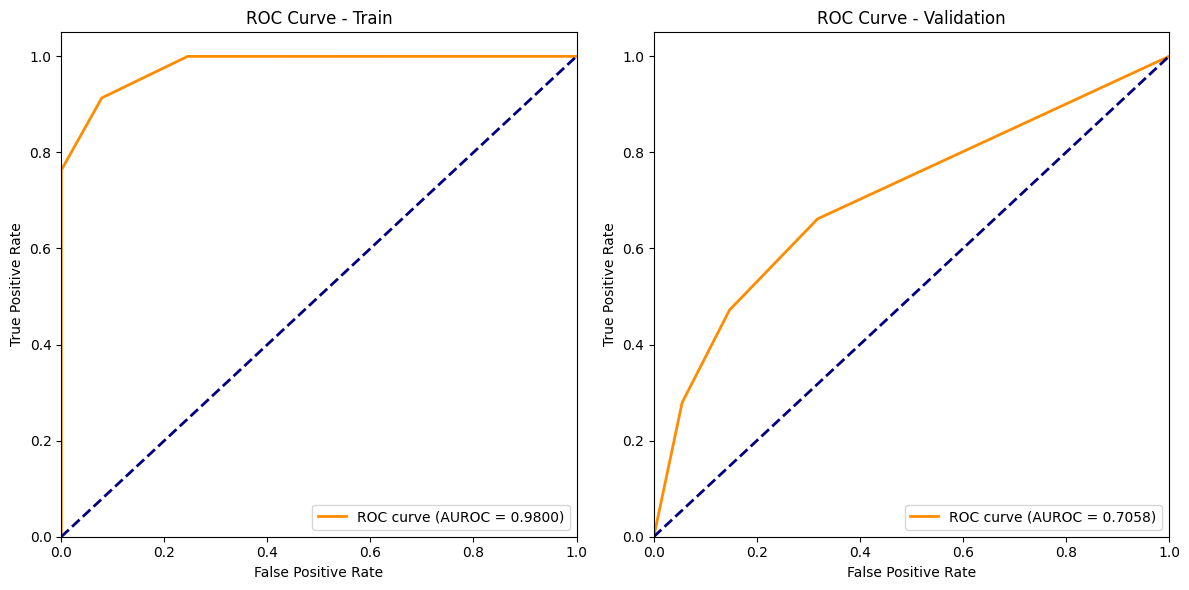

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8823 │           0.3589 │
│ roc_auc  │      0.9800 │           0.7058 │
└──────────┴─────────────┴──────────────────┘

k=5


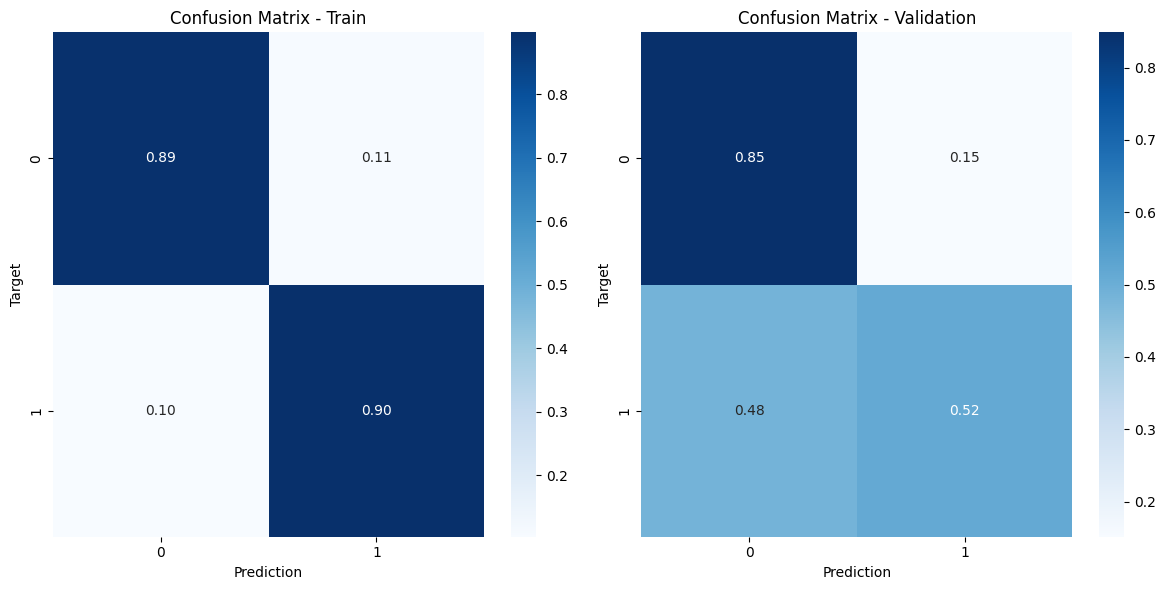

AUROC for Train dataset: 0.9661
AUROC for Validation dataset: 0.7273


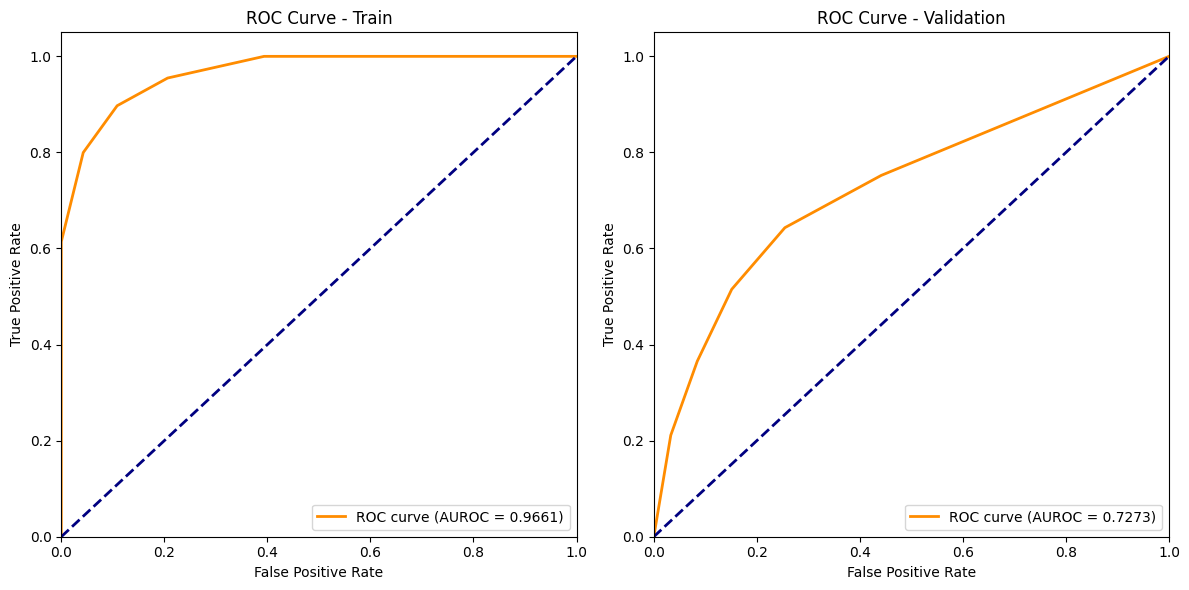

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8488 │           0.3806 │
│ roc_auc  │      0.9661 │           0.7273 │
└──────────┴─────────────┴──────────────────┘

k=10


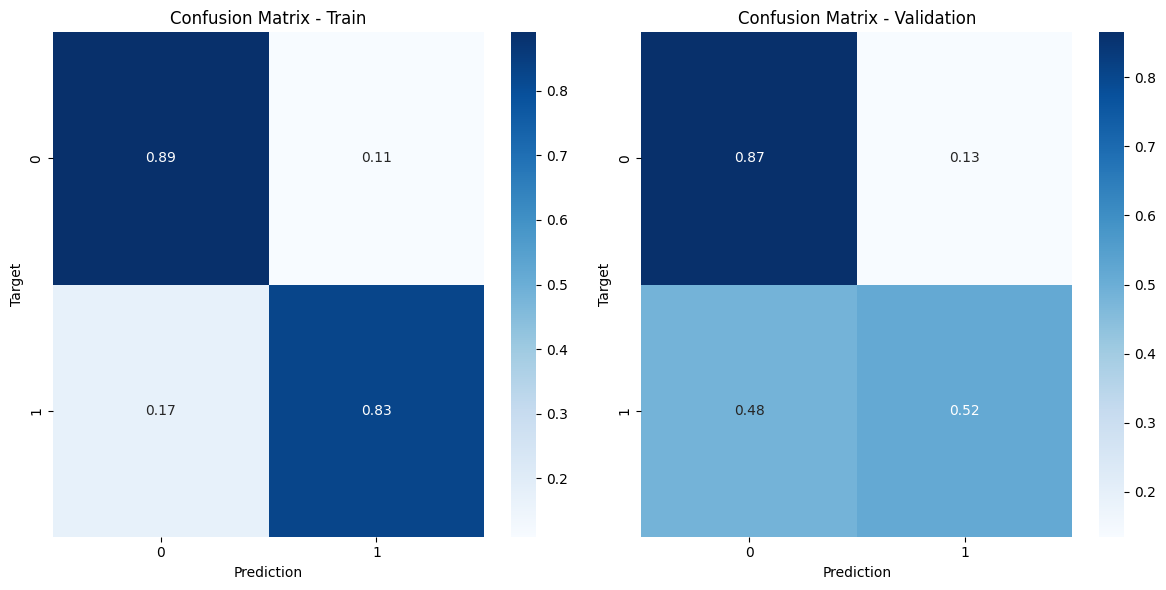

AUROC for Train dataset: 0.9414
AUROC for Validation dataset: 0.7421


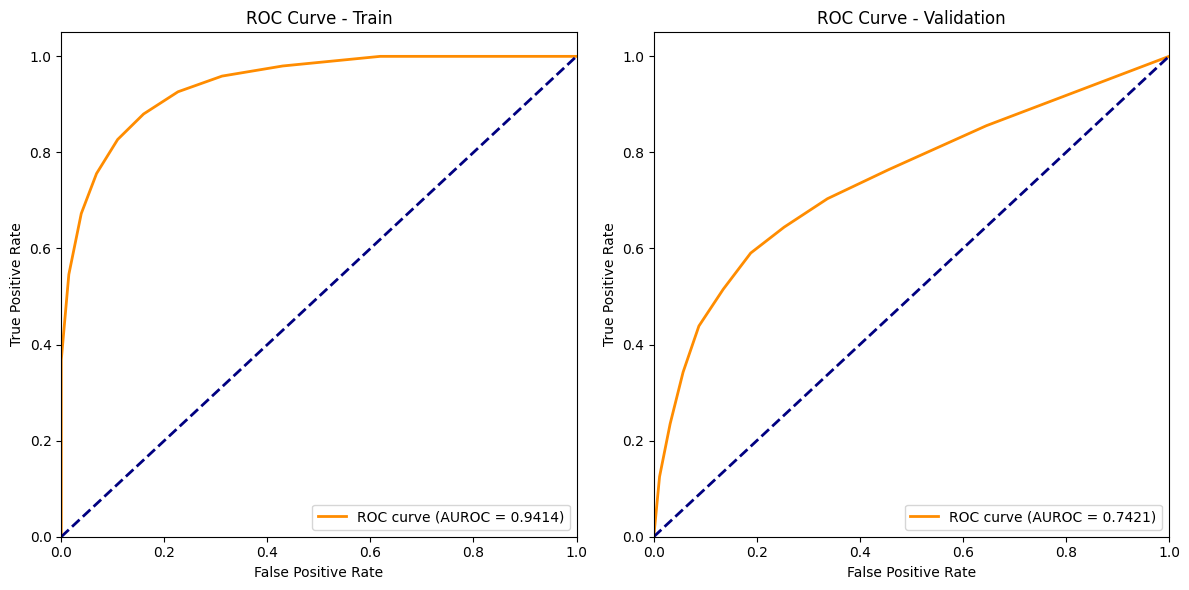

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8084 │           0.3998 │
│ roc_auc  │      0.9414 │           0.7421 │
└──────────┴─────────────┴──────────────────┘

In [19]:
K = [3, 5, 10]
knn_models_res = {}

for k in K:
    knn_model = KNNModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, n_neighbors=k).fit().predict()
    print(f"k={k}")
    model_comparator.add_model(knn_model, f"kNN k={k} with resampling")
    knn_model.display_confusion_matrix()
    knn_model.display_roc_auc()
    model_comparator.display_metrics(knn_model.compute_all_metrics())

    knn_models_res[k] = knn_model

**Загальні спостереження про моделі**:

k=3:

- Модель дуже добре передбачає негативні випадки: 89% реальних «Ні» правильно передбачено як «Ні».
- Лише 10% (та 19% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 3% (на тренуванні) та 49% (на валідації) помилково передбачені як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує майже всі позитивні значення (~96%), але на валідації показник падає до 51%, що свідчить про сильне перенавчання.
- Бачимо значний розрив між значеннями метрик на тренувальному та валідаційному наборах даних.
- Явно виражене перенавчання – AUROC на тренуванні дуже високий, а на валідації падає.
-F1-score також суттєво зменшується, що підтверджує перенавчання.
- Загалом модель добре працює на тренувальних даних, але гірше на нових.
- Ресемплінг допоміг зменшити перекіс у класах, але модель все ще погано узагальнює.
- Краще розпізнає "Ні", ніж "Так".

k=5:

- Модель добре передбачає негативні випадки: 83% реальних «Ні» правильно передбачено як «Ні».
- Лише 16% (та 22% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 3% (на тренуванні) та 42% (на валідації) передбачено як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 96% позитивних значень, але на валідації цей показник падає до 57%.
- Різниця між значеннями AUROC метрики для тренувального та валідаційного наборів зменшилася порівняно з k=3, але все ще є розрив між Train та Validation.
- F1-score став більш стабільним, але все ще низький.
- Загалом модель все ще демонструє перенавчання, але його рівень зменшився.
- Модель краще розпізнає "Ні", але продовжує мати проблеми з розпізнаванням "Так".

k=10:

- Модель добре передбачає негативні випадки: 80% реальних «Ні» правильно передбачено як «Ні».
- Лише 19% (та 22% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 5% (на тренуванні) та 38% (на валідації) передбачено як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 94% позитивних значень, але на валідації цей показник падає до 61%.
- Перенавчання зменшилося, що видно по значенню метрики AUROC.
- F1-score все ще слабкий, але краще за k=3 та k=5.
- Загалом k=10 показує найкращий баланс між перенавчанням та узагальненням серед kNN з ресемплінгом.


**Загальні спостереження про модельювання за допомогою kNN на оригінальних даних без ресамплінгу**

Проведено моделювання kNN з різними значеннями k (3, 5, 10) на збалансованому датасеті. Основні висновки:

- Чим менше k (k=3), тим сильніше перенавчання – модель запам’ятовує тренувальні дані, але гірше працює на валідації.
- Чим більше k (k=10), тим краще баланс між перенавчанням та узагальненням, але все ще погано визначає позитивний клас.
- Ресемплінг допомагає вирівняти баланс класів, але не вирішує проблему низького recall для "Так".
- Навіть при збільшенні k результати не сильно покращуються – перенавчання зменшується, але якість прогнозів не досягає рівня логістичної регресії.
- kNN з ресемплінгом все ще не є ефективним для задачі передбачення підписки.

In [20]:
model_comparator.update_model_comment(knn_models_res[3],
                                      "Перенавчена модель. Ресемплінг покращив TPR для класу 1, але AUC впав з 0.99 (train) до 0.70 (val). F1-score дуже слабкий (0.34). k=3 занадто чутливе до шуму.")
model_comparator.update_model_comment(knn_models_res[5],
                                      "Перенавчена модель. Ресемплінг покращив TPR для класу 1, але AUC впав з 0.98 (train) до 0.72 (val). F1-score залишився слабким (0.35). k=5 трохи краще за k=3, але все ще неефективне.")
model_comparator.update_model_comment(knn_models_res[10],
                                      "Посередня модель. Найкраще значення AUC серед kNN з ресемплінгом (0.73 на val), але F1-score залишився слабким (0.36). k=10 зменшило перенавчання.")

### DecisionTreeModel

#### Baseline модель

Натренуємо звичайну просту модель дерева прийнятя рішеннь.

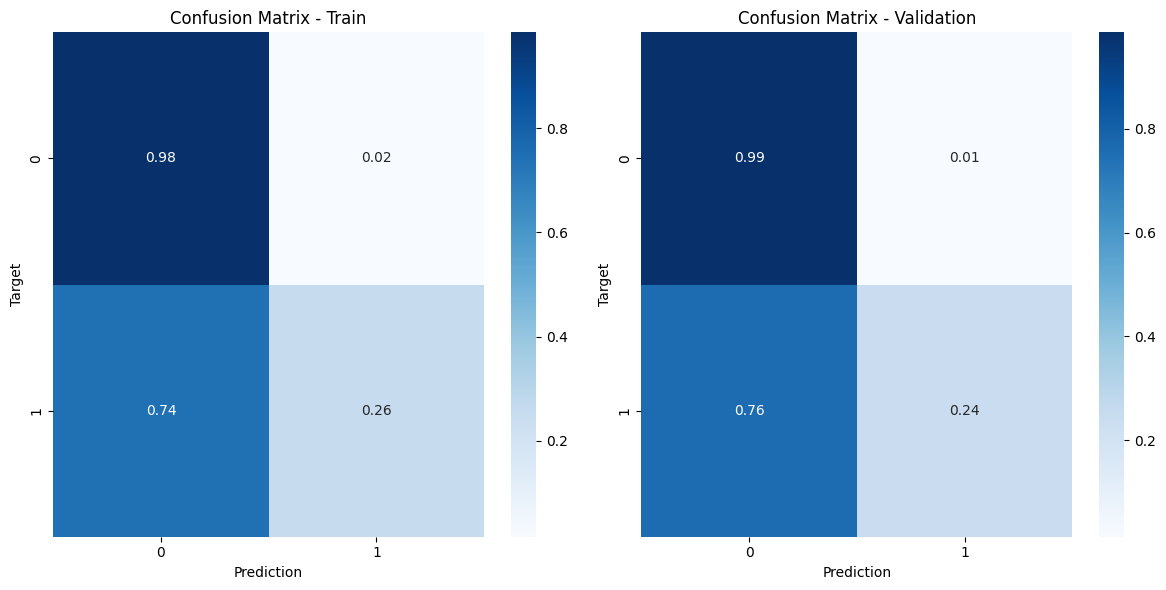

AUROC for Train dataset: 0.7854
AUROC for Validation dataset: 0.7955


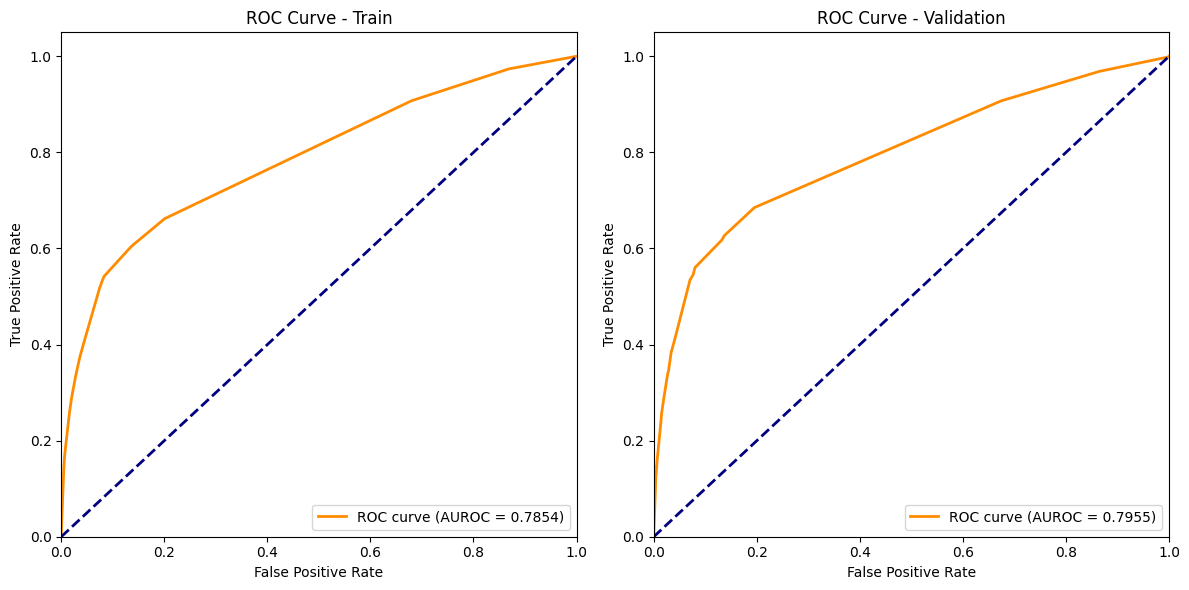

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3717 │           0.3559 │
│ roc_auc  │      0.7854 │           0.7955 │
└──────────┴─────────────┴──────────────────┘

In [21]:
tree_model_d5 = DecisionTreeModel(X_train, y_train, X_val, y_val, max_depth=5).fit().predict()
evaluate_model(tree_model_d5, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (на валідаційних 1%) помилково передбачено укладання депозиту для тих, хто не уклав. Отже маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 74% (76% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 26% позитивних значень, але на валідації показник падає до 24%. Точність передбачення підписки все ще низька.
- Бачимо, що значення метрики roc auc подібні, на валідаційному наборі навіть трошки вище.
- Порівняно з KNN, дерево краще узагальнює та не перенавчається.

**Загальні спостереження про модель**:

- Дана модель працює приблизно так само, як і розглянуті моделі логістичної регресії.
- Decision Tree трохи краще моделює нелінійні залежності, але при цьому не дає значного приросту точності.
- При збільшенні max_depth, щоб покращити узагальнення, ймовірно зіштовхнемося з проблемою перенавчання моделі.

In [22]:
model_comparator.update_model_comment(tree_model_d5,
                                      "Посередня модель. Стабільна, без перенавчання, але дуже низький recall для класу 1.")

#### Model with manually tuned hyperparameters

Спробуємо вручну підбрати гіперпараметри, за застосувати крос валідацію.

Running cross-validation before training...
Cross-validation roc_auc: 0.7773 ± 0.0039


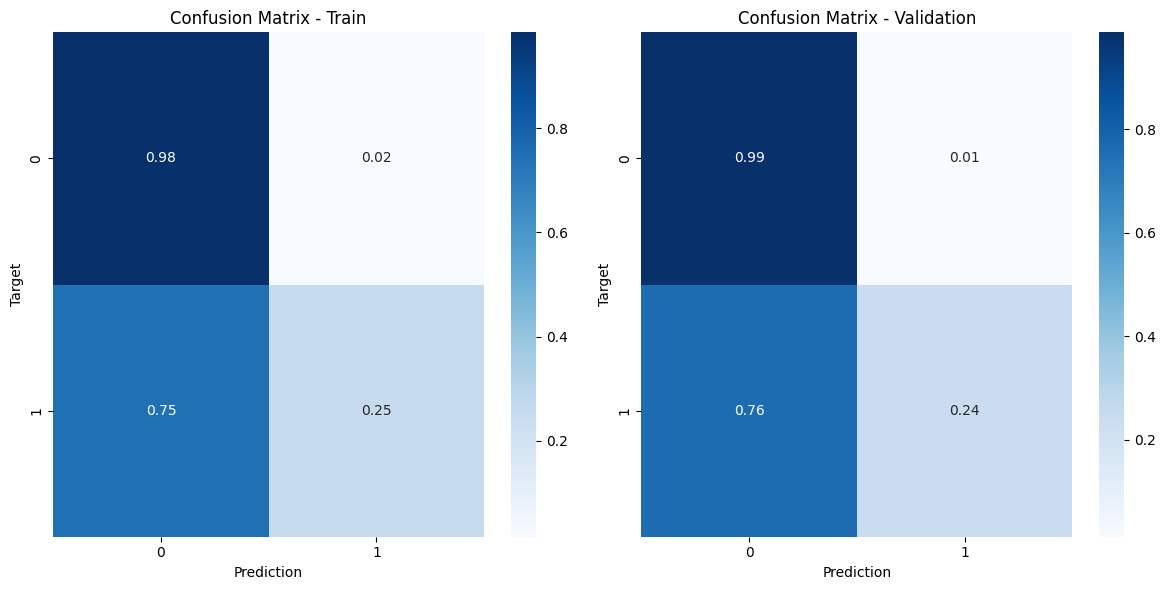

AUROC for Train dataset: 0.7853
AUROC for Validation dataset: 0.7957


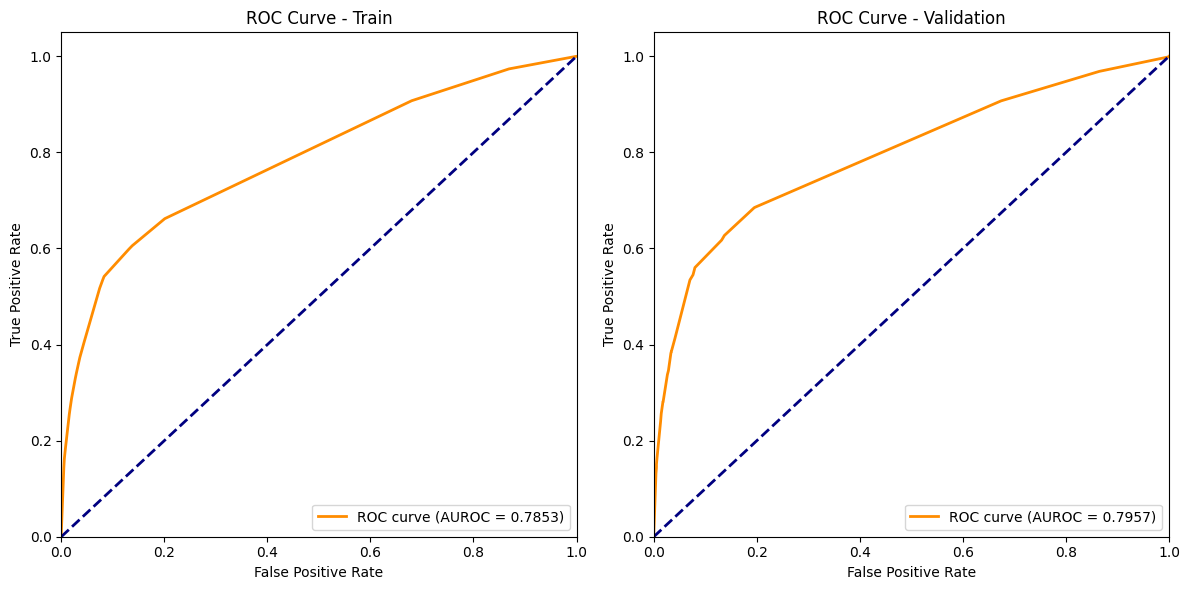

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3695 │           0.3574 │
│ roc_auc  │      0.7853 │           0.7957 │
└──────────┴─────────────┴──────────────────┘

In [23]:
dt_model_cv = DecisionTreeModel(X_train, y_train, X_val, y_val, max_depth=5, enable_cv=True,
                                min_samples_split=10, min_samples_leaf=5, cv_params={"cv": 5}
                                ).fit().predict()
evaluate_model(dt_model_cv, "Added cross validation.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (на валідаційних 1%) помилково передбачено укладання депозиту для тих, хто не уклав. Отже, маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 75% (76% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 25% позитивних значень, але на валідації показник падає до 24%. Точність передбачення підписки все ще низька.
- Бачимо, що значення метрики подібні, на валідаційному наборі навіть трошки вище.
- Загалом, можемо сказати, що модель не перенавчається.
- Модель показала дуже схожі результати на тренувальних та валідаційних даних, що означає, що вона не перенавчається.
- Значення метрики F1-score достатньо низьке.
- Модель дерева прийняття рішень показує стабільні результати, але має низьку чутливість до позитивного класу.
- Додавання крос-валідації не призвело до значного покращення, результати дуже схожі на baseline дерево рішень.


In [24]:
model_comparator.update_model_comment(dt_model_cv,
                                      "Посередня модель. Крос-валідація трохи стабілізувала AUROC, але якість прогнозів не покращилась. Recall для класу 1 залишається низьким.")

#### Model with manually tuned hyperparameters and resampling

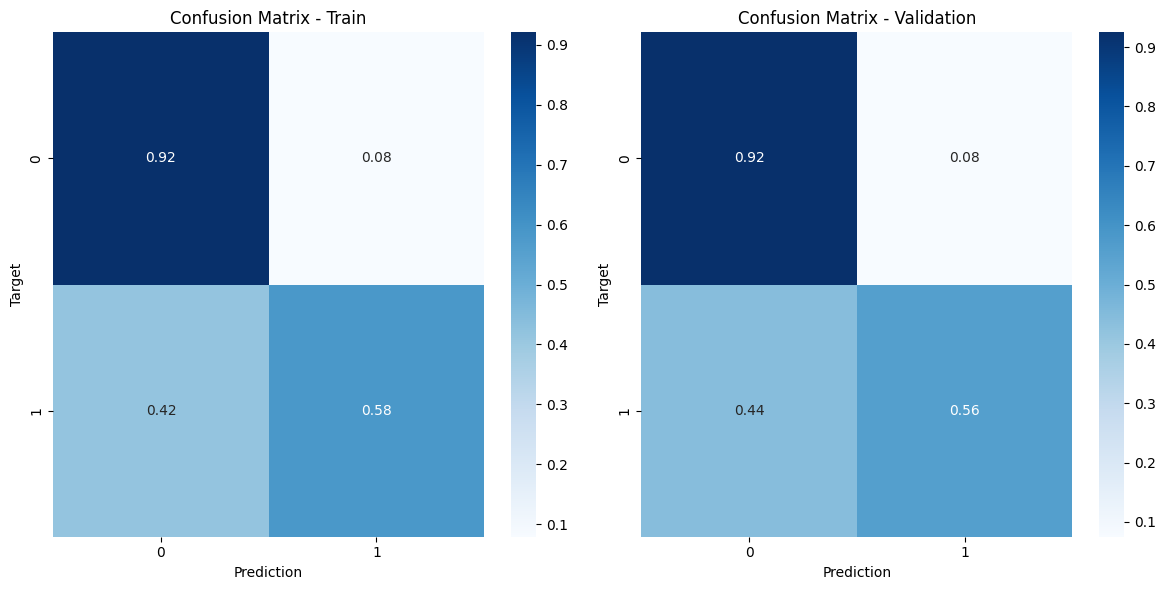

AUROC for Train dataset: 0.8046
AUROC for Validation dataset: 0.7805


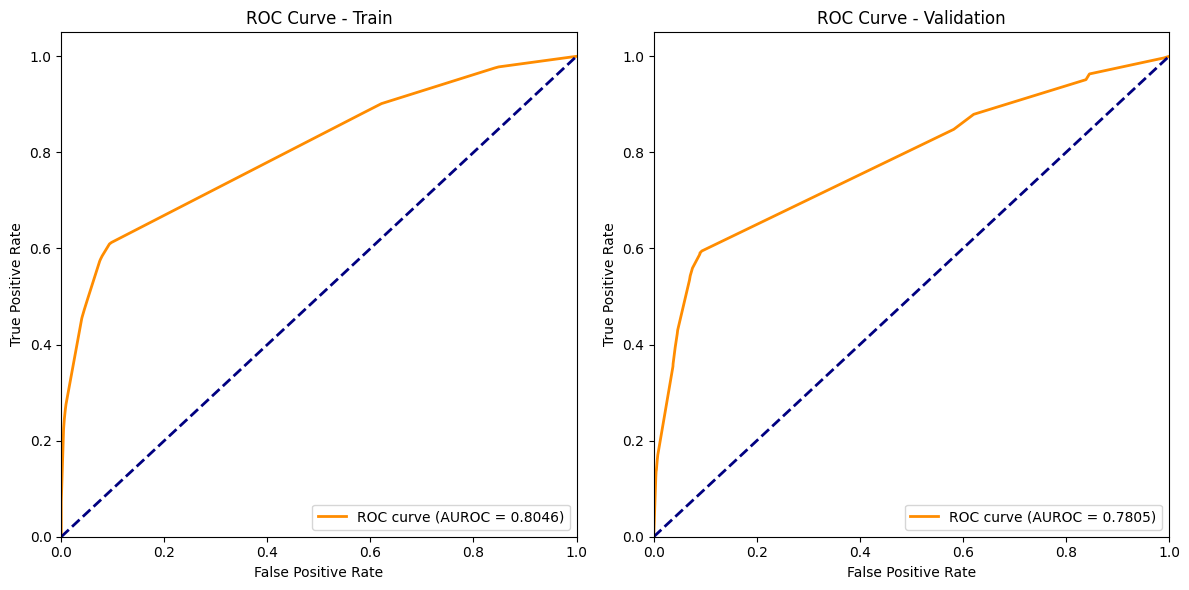

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.6705 │           0.5200 │
│ roc_auc  │      0.8046 │           0.7805 │
└──────────┴─────────────┴──────────────────┘

In [25]:
dt_model_rs = DecisionTreeModel(
    X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, max_depth=5, min_samples_split=10,
    min_samples_leaf=5).fit().predict()
evaluate_model(dt_model_rs, "With resampling.")

**Спостереження**:

- Модель добре передбачає негативні випадки: 91.8% реальних "Ні" правильно передбачено як "Ні".
- 8.2% (та 8.5% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків значно менше, ніж у попередніх моделях: 39% (на тренуванні) → 44.9% (на валідації) класифіковані неправильно.
- AUROC зросло на тренувальних даних та залишилося стабільним на валідації.
- Бачимо значне падіння F1 на валідації, що вказує на перенавчання.
- Модель краще розпізнає клас "Так", ніж у попередніх версіях DecisionTree, але маємо перенавчання моделі.
- Ресемплінг допоміг покращити баланс між класами, але все ще є занижений recall для класу "Так".

In [26]:
model_comparator.update_model_comment(dt_model_rs,
                                      "Хороша модель, але з перенавчанням. Ресемплінг покращив баланс класів, але AUROC на валідації залишився посереднім.")

### RandomForest

#### Baseline model

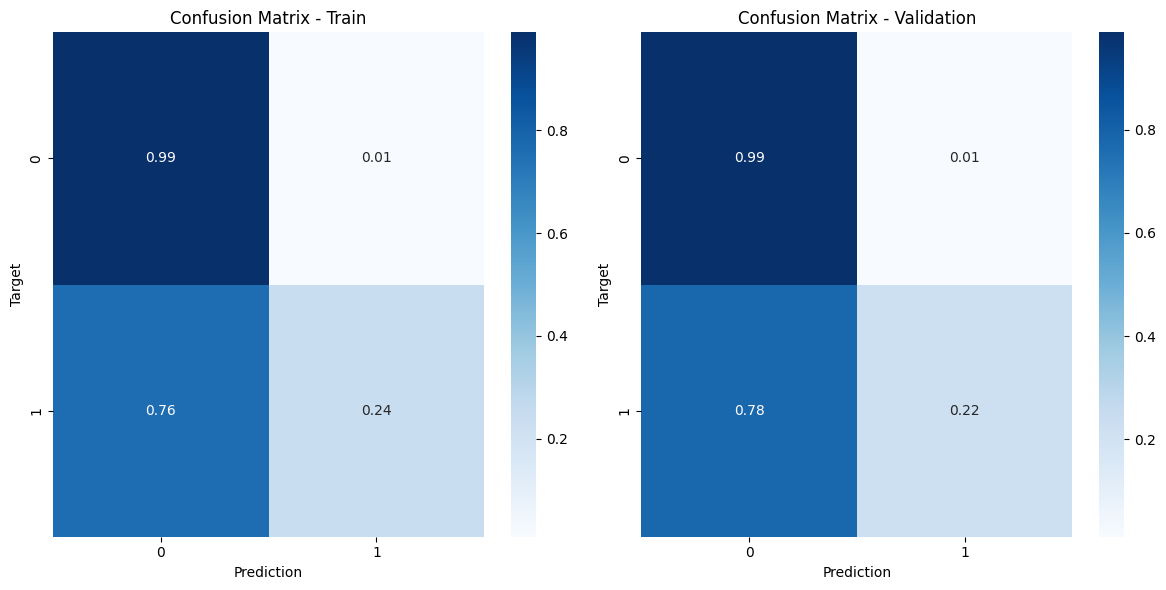

AUROC for Train dataset: 0.8379
AUROC for Validation dataset: 0.8097


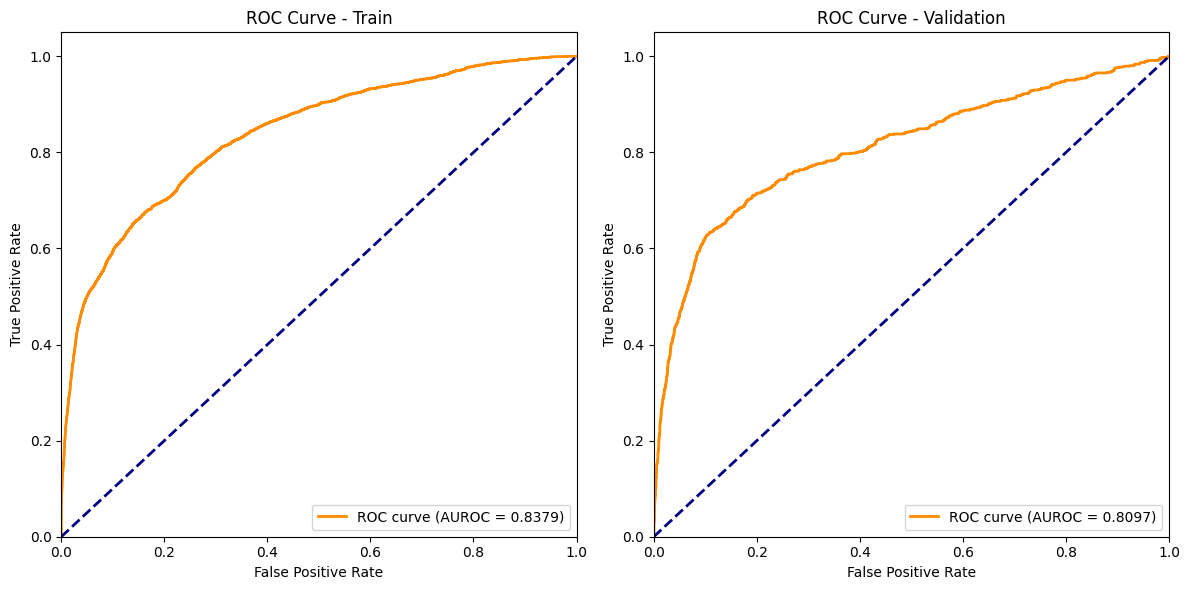

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3670 │           0.3336 │
│ roc_auc  │      0.8379 │           0.8097 │
└──────────┴─────────────┴──────────────────┘

In [27]:
rf_model = RandomForestModel(X_train, y_train, X_val, y_val, n_estimators=150, max_depth=10, min_samples_split=5,
                             min_samples_leaf=10).fit().predict()
evaluate_model(rf_model, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1%  помилково передбачено укладання депозиту для тих, хто не уклав. Отже, маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 76% (78% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 24% позитивних значень, але на валідації показник падає до 22%. Точність передбачення підписки все ще низька.
- Бачимо, що зі використанням RandomForest значення метрики roc-auc підвищилось, відносно бвзових моделей.
- Присутній невелика різниця в значеннях для тренувального та валідаційного наборів.
- Отже, мажмо перенавчання, але вже не таке сильне як у попередніх моделей.
- Модель продемонструвала вищу якість за попередні, хоча модель перенавчилася.
- Проблема визначення позитивного класу все ще актуальна.

In [28]:
model_comparator.update_model_comment(rf_model,
                                      "Хороша модель за AUROC, але слабкий F1-score. Добре розпізнає клас 'Ні', але погано класифікує 'Так'.")

#### Model with resampling

Спробуємо застосувати ресамплінг

Running cross-validation before training...
Cross-validation roc_auc: 0.9507 ± 0.0038


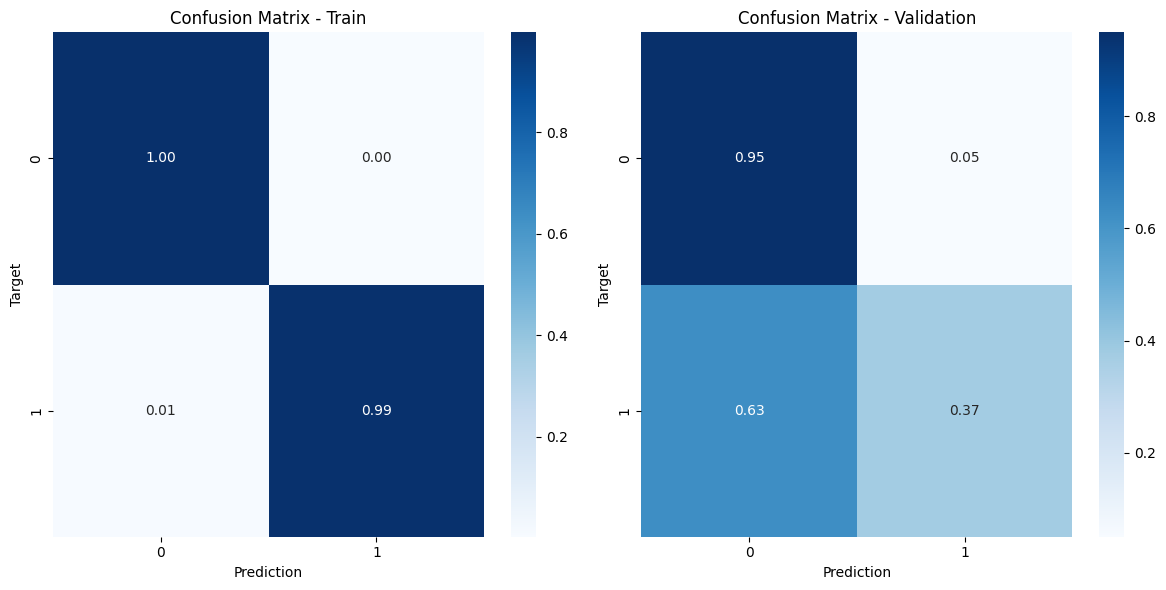

AUROC for Train dataset: 0.9999
AUROC for Validation dataset: 0.7766


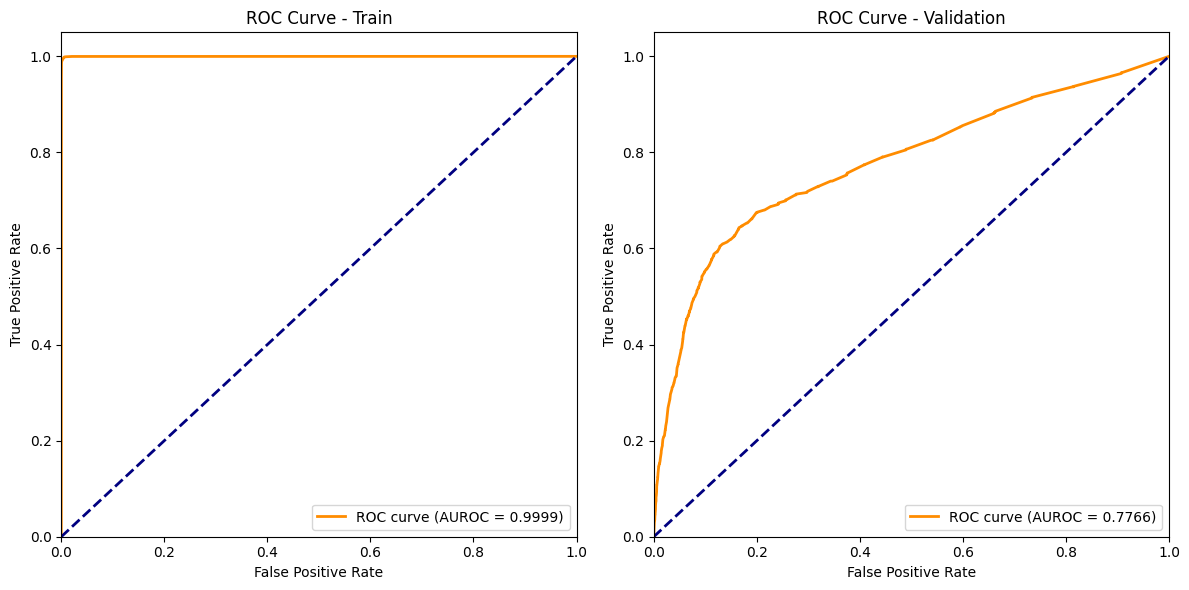

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.9944 │           0.4232 │
│ roc_auc  │      0.9999 │           0.7766 │
└──────────┴─────────────┴──────────────────┘

In [29]:
rf_params = {"n_estimators": 100, "max_depth": 10, "min_samples_split":5, "min_samples_leaf":10}

rf_model_rs_sm = RandomForestModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, rf_params).fit().predict()
evaluate_model(rf_model_rs_sm, "With data resampling.")

**Спостереження**:

- Модель добре передбачає негативні випадки
- AUROC зросло на тренувальних даних та залишилося стабільним на валідації.
- Маємо значне падіння F1 на валідації, що вказує на перенавчання, але все ж таки краще, ніж у базовій версії.
- Ресемплінг допоміг покращити баланс між класами, що видно по значному покращенню F1-score.
- AUROC залишився високим (0.80+), що є хорошим результатом, але має місце і перенавчання.

Варто зазначити, що модель не є стабліьною, до того схильна до пренавчання, тому в даному вигляді не може бути використана

In [30]:
model_comparator.update_model_comment(rf_model_rs_sm,
                                      "Хороша модель. Не може бути використана через не стабільність і схильність до перенавчання. Ресемплінг покращив баланс класів: F1-score зріс.")

### XGBModel

#### Baseline XGBModel

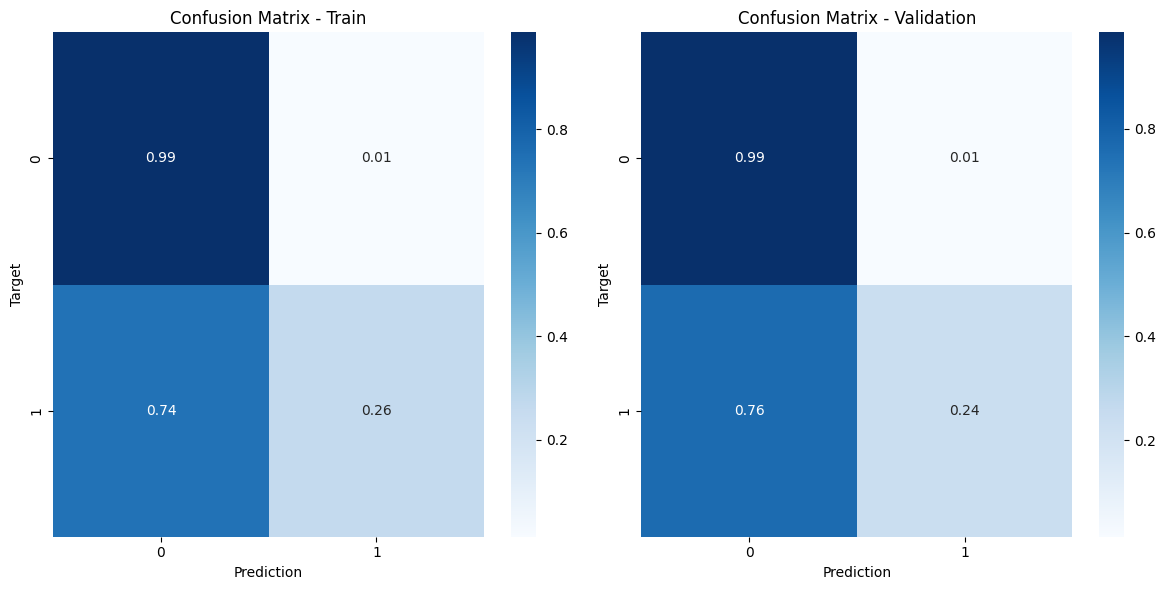

AUROC for Train dataset: 0.8203
AUROC for Validation dataset: 0.8147


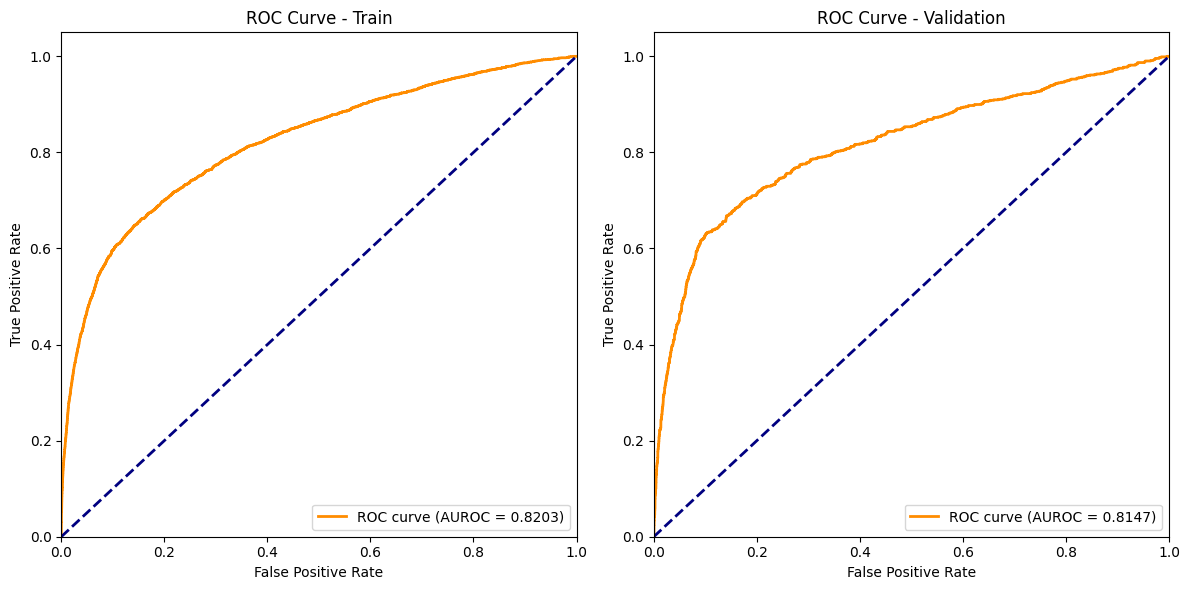

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3825 │           0.3523 │
│ roc_auc  │      0.8203 │           0.8147 │
└──────────┴─────────────┴──────────────────┘

In [31]:
xgb_model_params = {"learning_rate": 0.05, "n_estimators": 150, "max_depth": 4}
xgb_model = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                     params=xgb_model_params).fit().predict()
evaluate_model(xgb_model, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98.7% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.3% помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 73.9% (на тренуванні) → 76.3% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо стабільність, без значного перенавчання.
- Значення метркии F1-score все ще слабке.
- Модель не демонструє сильного перенавчання, але все ще погано розпізнає позитивний клас.
- XGBoost показує хороший баланс між навчальною та тестовою вибірками.
- F1-score залишається низьким, що говорить про проблеми з точним передбаченням класу "Так".
- Модель працює стабільніше, ніж попередні алгоритми, але ще потребує покращення.

In [32]:
model_comparator.update_model_comment(xgb_model,
                                      "Хороша модель. Високий AUROC, стабільна без перенавчання. F1-score все ще слабкий, що вказує на проблеми з розпізнаванням позитивного класу.")

#### XGBModel with tuning hyperparameters via RandomizedSearchCV

In [33]:
xgb_space_random = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': np.linspace(0.01, 0.05, 10),
    'max_depth': np.arange(3, 7, 1),
    'min_child_weight': np.arange(5, 15, 1),
    'subsample': np.linspace(0.5, 0.8, 10),
    'colsample_bytree': np.linspace(0.5, 0.9, 10),
    'gamma': np.linspace(0.1, 1.0, 10),
    'reg_alpha': np.linspace(0.5, 2.0, 10),
    'reg_lambda': np.linspace(0.5, 2.0, 10)
}

In [34]:
tuner_random_xgb = RandomSearchTuner(XGBClassifier, X_train, y_train, X_val, y_val, xgb_space_random)
best_params_random_xgb = tuner_random_xgb.tune()

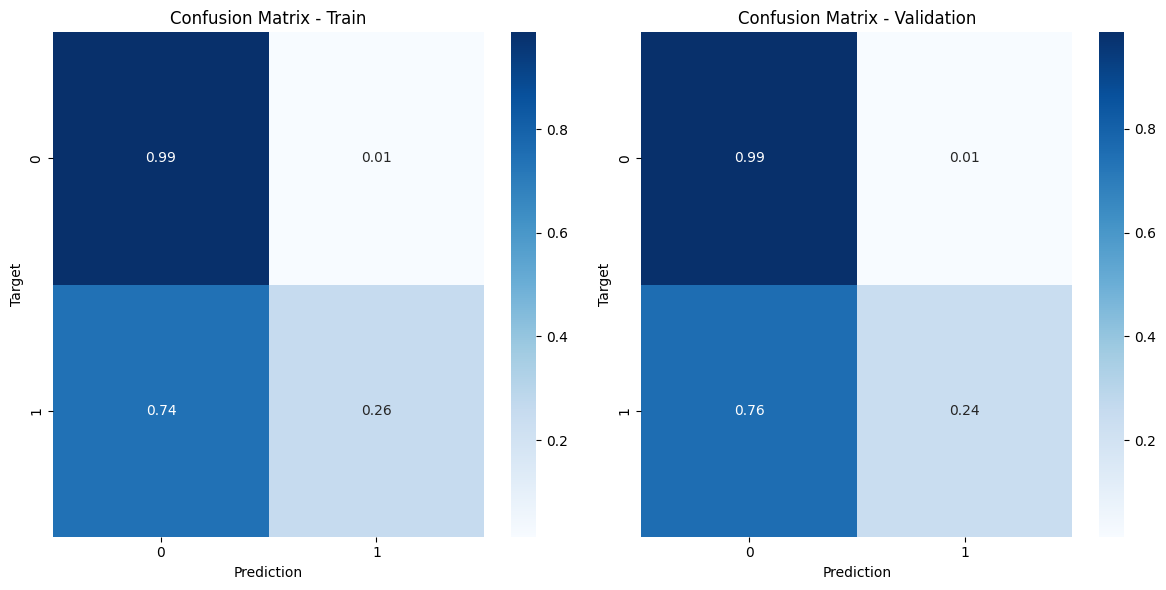

AUROC for Train dataset: 0.8213
AUROC for Validation dataset: 0.8151


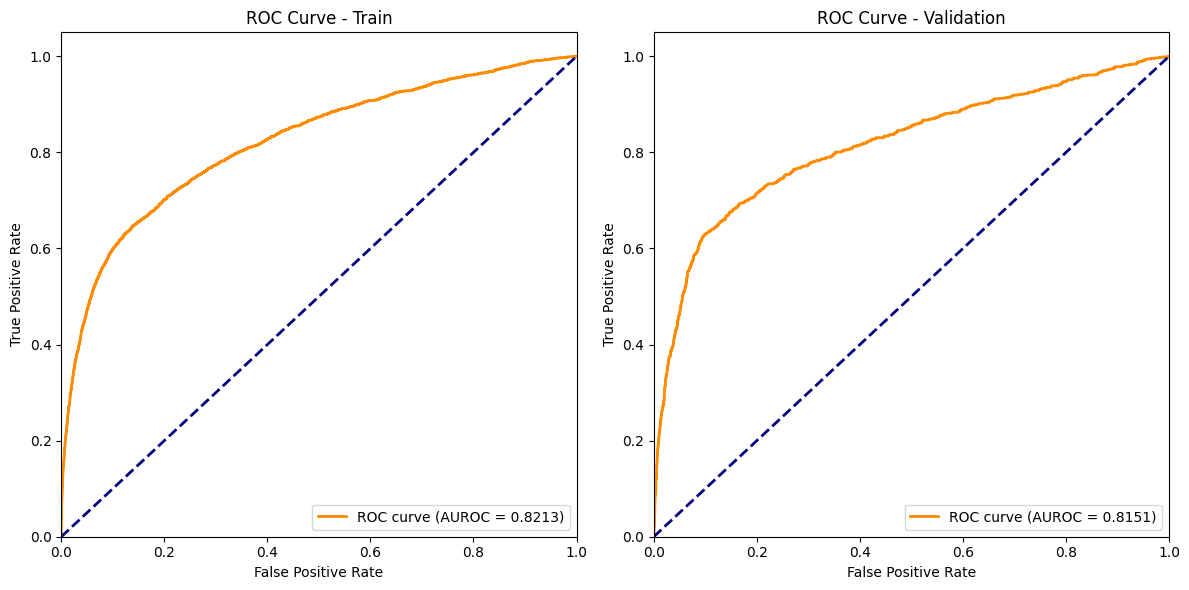

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3791 │           0.3620 │
│ roc_auc  │      0.8213 │           0.8151 │
└──────────┴─────────────┴──────────────────┘

In [35]:
xgb_model_r = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                       params=best_params_random_xgb).fit().predict()
evaluate_model(xgb_model_r, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 99% реальних "Ні" правильно передбачено як "Ні".
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 74% (на тренуванні) → 76% (на валідації) передбачено як "Ні", коли насправді "Так".
- Значення метркии AUROC стабільнеь, без значного перенавчання.
- Модель не демонструє сильного перенавчання, але все ще погано розпізнає позитивний клас.
- Налаштування гіперпараметрів за допомогою RandomizedSearchCV не призвело до значного покращення.
- XGBoost після RandomizedSearchCV зберіг стабільність і високий AUROC, але не покращив F1-score.
- Гіперпараметричний тюнінг не дав значного покращення в продуктивності.
- Модель залишається стабільною, але потребує додаткової оптимізації для кращого балансу між precision та recall.

In [36]:
model_comparator.update_model_comment(xgb_model_r,
                                      "Хороша модель. Після RandomizedSearchCV AUROC залишився стабільним, але F1-score все ще слабкий. Оптимізація не дала значного покращення.")

#### XGBModel with tuning hyperparameters via RandomizedSearchCV and resampling

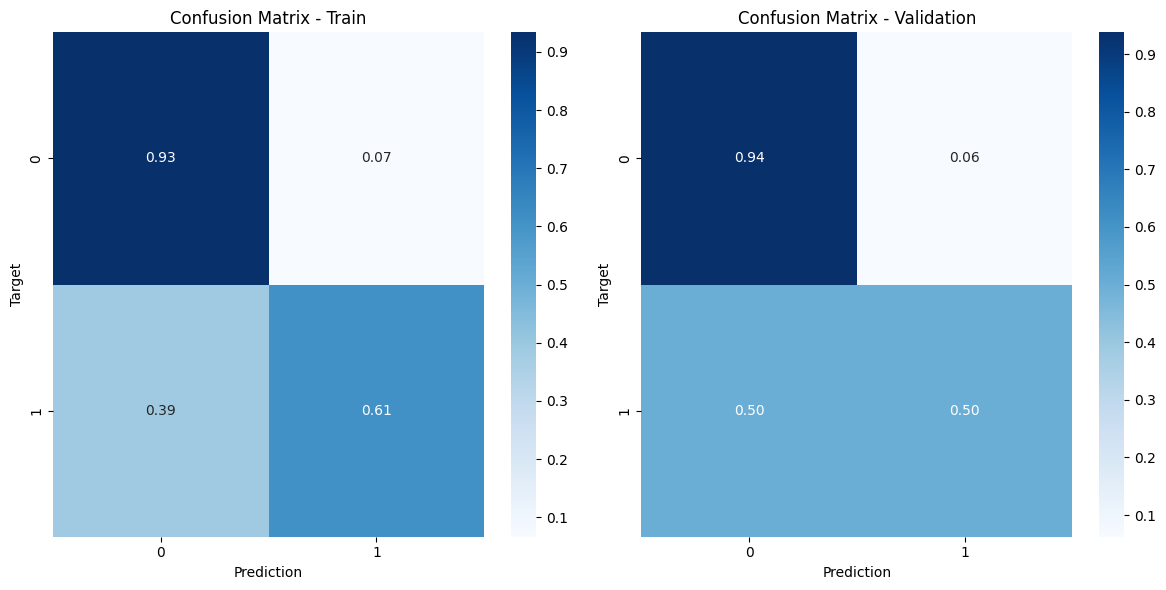

AUROC for Train dataset: 0.8916
AUROC for Validation dataset: 0.7973


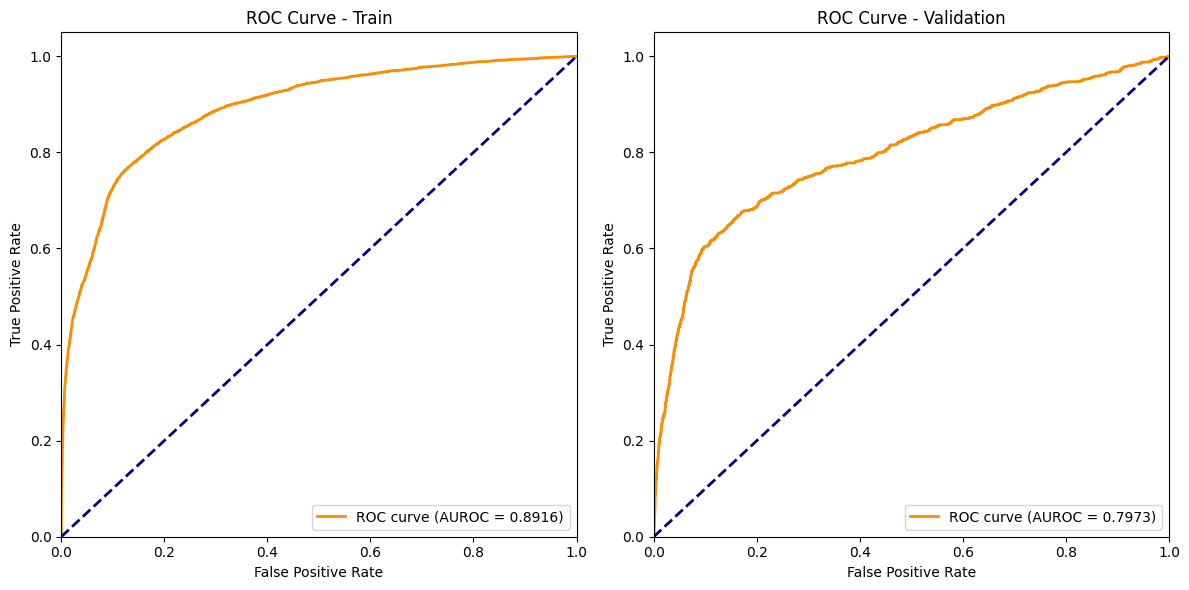

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.6997 │           0.5022 │
│ roc_auc  │      0.8916 │           0.7973 │
└──────────┴─────────────┴──────────────────┘

In [37]:
xgb_model_r_s = XGBModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                         params=best_params_random_xgb).fit().predict()
evaluate_model(xgb_model_r_s, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 90.7% реальних "Ні" правильно передбачено як "Ні".
- Лише 9.3% (та 9.6% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків значно менше, ніж у попередніх моделях:22.5% (на тренуванні) → 44.3% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зачнння AUROC демонструє значне AUROC на тренуванні, але все значно нижщий на валідації.
- Для F1-score маємо значне падіння F1 на валідації, що вказує на певне перенавчання.
- Ресемплінг суттєво покращив здатність розпізнавати позитивний клас, але перенавчання все ще присутнє.
- F1-score значно зріс на тренуванні (0.83), але на валідації залишився нижчим за 0.50, що вказує на складність узагальнення.

In [38]:
model_comparator.update_model_comment(xgb_model_r_s,
                                      "Хороша модель з певним перенавчанням. Ресемплінг покращив баланс класів: AUROC зріс, F1-score покращився, але все ще нижчий за 0.50 на валідації.")

#### XGBModel with tuning hyperparameters via Hyperopt

In [39]:
tuner_hyperopt_xgb = HyperoptTuner(XGBClassifier, X_train, y_train, X_val, y_val, xgb_space_random)
best_params_hyperopt_xgb = tuner_hyperopt_xgb.tune()

 45%|████▌     | 9/20 [00:07<00:09,  1.18trial/s, best loss: -0.816637356125289]


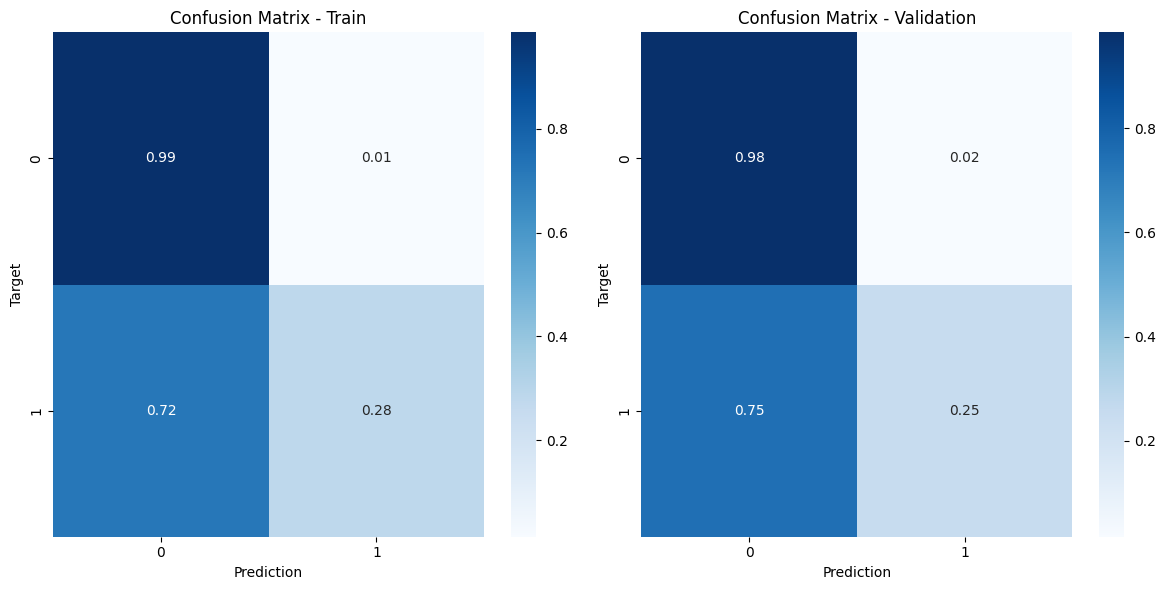

AUROC for Train dataset: 0.8341
AUROC for Validation dataset: 0.8166


          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4058 │           0.3672 │
│ roc_auc  │      0.8341 │           0.8166 │
└──────────┴─────────────┴──────────────────┘

In [40]:
xgb_model_h = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                       params=best_params_hyperopt_xgb).fit().predict()
evaluate_model(xgb_model_h, "With Hyperopt tuning")

**Спостереження**:
- Модель добре передбачає негативні випадки: 98.4% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.4% (та 1.6% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків 71.2% (на тренуванні) → 75.0% (на валідації) передбачено як "Ні", коли насправді "Так".
- Модель не демонструє сильного перенавчання, але все ще має проблеми з розпізнаванням позитивного класу.
- Гіперпараметричний тюнінг через Hyperopt трохи покращив F1-score і стабілізував AUROC.
- Hyperopt допоміг знайти трохи кращі параметри для F1-score та стабільності AUROC.
- F1-score покращився порівняно з попередніми версіями XGBoost, але все ще не ідеальний.
- Ця версія XGBoost демонструє кращий баланс між узагальненням і продуктивністю.

In [41]:
model_comparator.update_model_comment(xgb_model_h,
                                      "Хороша модель. Hyperopt стабілізував AUROC та трохи покращив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### XGBModel with tuning hyperparameters via Hyperopt with resampling

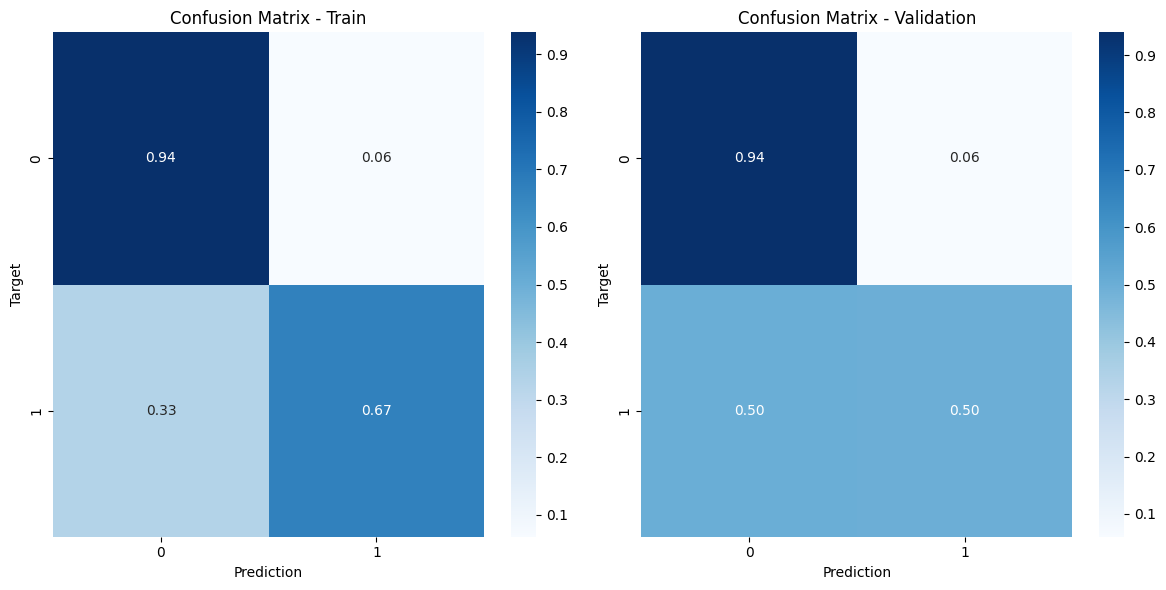

AUROC for Train dataset: 0.9095
AUROC for Validation dataset: 0.7985


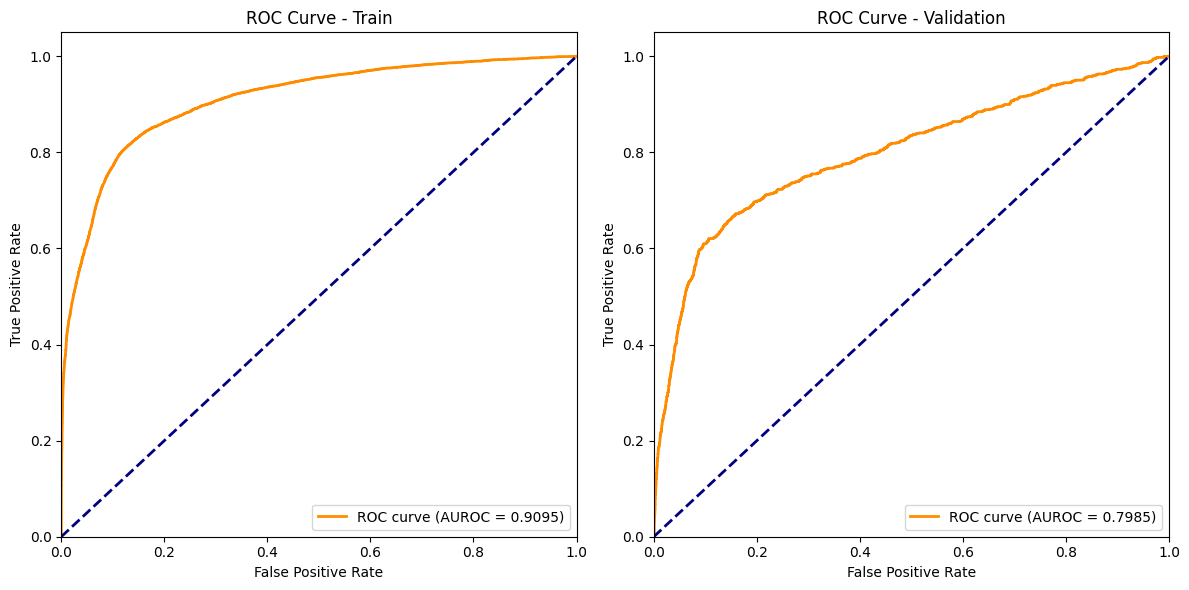

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7436 │           0.5055 │
│ roc_auc  │      0.9095 │           0.7985 │
└──────────┴─────────────┴──────────────────┘

In [42]:
xgb_model_h_rs = XGBModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                       params=best_params_hyperopt_xgb).fit().predict()
evaluate_model(xgb_model_h_rs, "With Hyperopt tuning")

**Спостереження**:

- Модель добре передбачає "негативні" випадки "Ні", як у тренувальному, так і у валідаційному наборі.
- Хоча після ресемплінгу показник Recall для класу Yes покращився, у валідаційних даних модель все ще неправильно класифікує половину позитивних випадків.
- На валідаційних даних AUC помітно знижується, маємо явне перенавчання.
- Помітне падіння F1-score на валідації (~0.50), що вказує на проблеми з балансом precision/recall.
- Модель не оптимально працює з класом "Так"

In [43]:
model_comparator.update_model_comment(xgb_model_h_rs,
                                      "Хороша модель. Все ще є проблеми з розпізнаванням позитивного класу. Наявне перенавчання - можна покращити узагальнюючу здатність.")

### LGBMModel

#### Baseline model

[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898


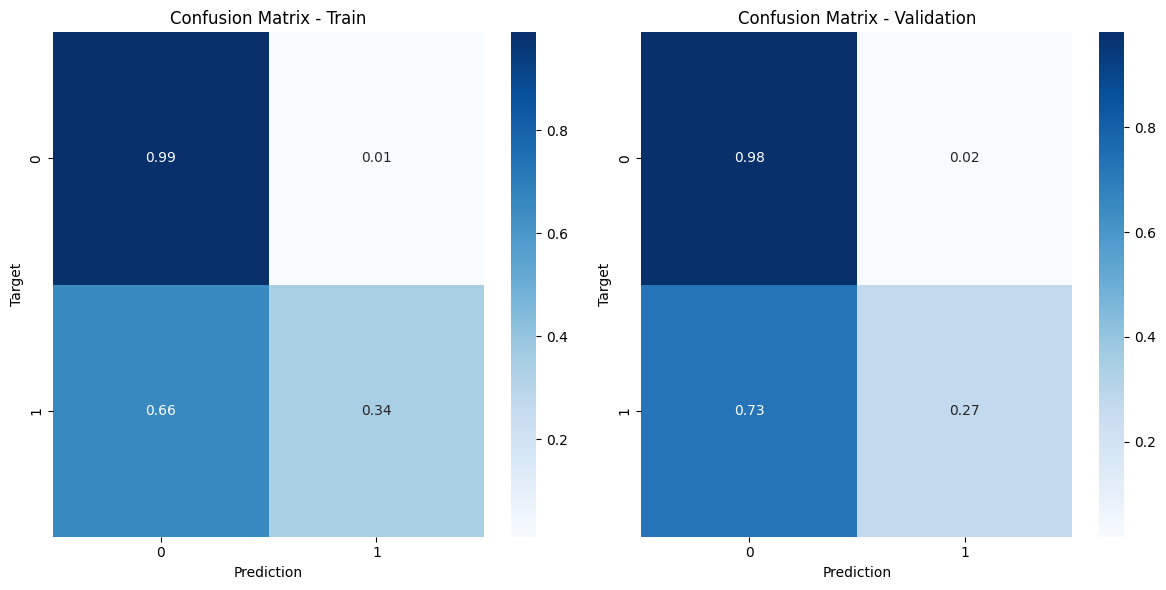

AUROC for Train dataset: 0.8943
AUROC for Validation dataset: 0.8129


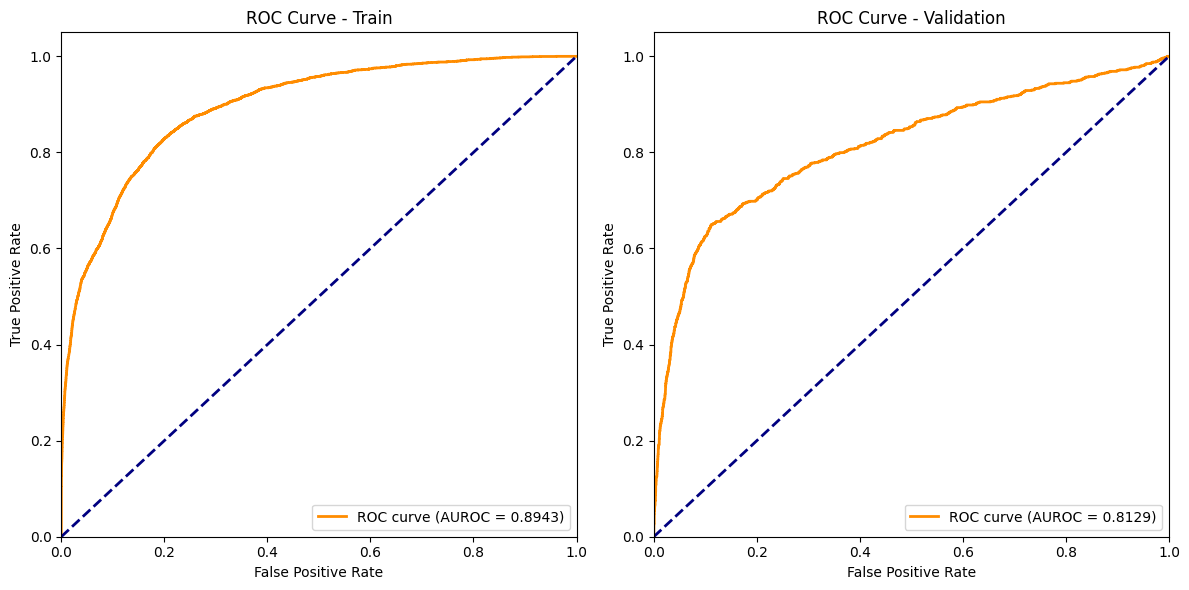

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4821 │           0.3823 │
│ roc_auc  │      0.8943 │           0.8129 │
└──────────┴─────────────┴──────────────────┘

In [44]:
lgbm_model_params = {"learning_rate": 0.05, "n_estimators": 200, "num_leaves": 40}
lgbm_model = LGBMModel(
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, params=lgbm_model_params
).fit().predict()

evaluate_model(lgbm_model, "Baseline model.")

**Спостереження**:
- Модель дуже добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 2% (та 1.0% на тренуванні) помилково передбачено укладання депозиту для тих, хто не уклав.
- 66% (на тренуванні) → 73% (на валідації) передбачено як "Ні", коли насправді "Так".
- Значення AUROC має розрив на тренуванні та валідації, що свідчить про перенавчання.
- F1-score порівняно краще, ніж у XGBoost, але все ще низький.
- Модель виглядає попередньо кращою за XGBoost у загальному розрізі, але перенавчання присутнє.
- F1-score все ще потребує покращення, оскільки модель має проблеми з передбаченням класу "Так".

In [45]:
model_comparator.update_model_comment(lgbm_model,
                                      "Хороша модель. Високий AUROC, але F1-score залишається низьким. Дещо є перенавчання, потрібно покращити балансування.")

#### LGBMModel with tuning hyperparameters via RandomizedSearchCV

In [46]:
lgb_space_rs = {
    'n_estimators': np.arange(50, 500, 25).astype(int),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 1).astype(int),
    'min_child_weight': np.arange(1, 11, 1).astype(int),
    'subsample': np.clip(np.linspace(0.5, 1.0, 10), 0.5, 1.0),
    'colsample_bytree': np.clip(np.linspace(0.5, 1.0, 10), 0.5, 1.0),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10),
    'min_split_gain': np.clip(np.linspace(0.001, 0.1, 10), 0.001, 0.1)  # Уникаємо 0
}

In [47]:
tuner_random_lgb = RandomSearchTuner(LGBMClassifier, X_train, y_train, X_val, y_val, lgb_space_rs)
best_params_random_lgb = tuner_random_lgb.tune()

In [48]:
lgb_model_r = LGBMModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                        params=best_params_random_lgb).fit().predict()

[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898


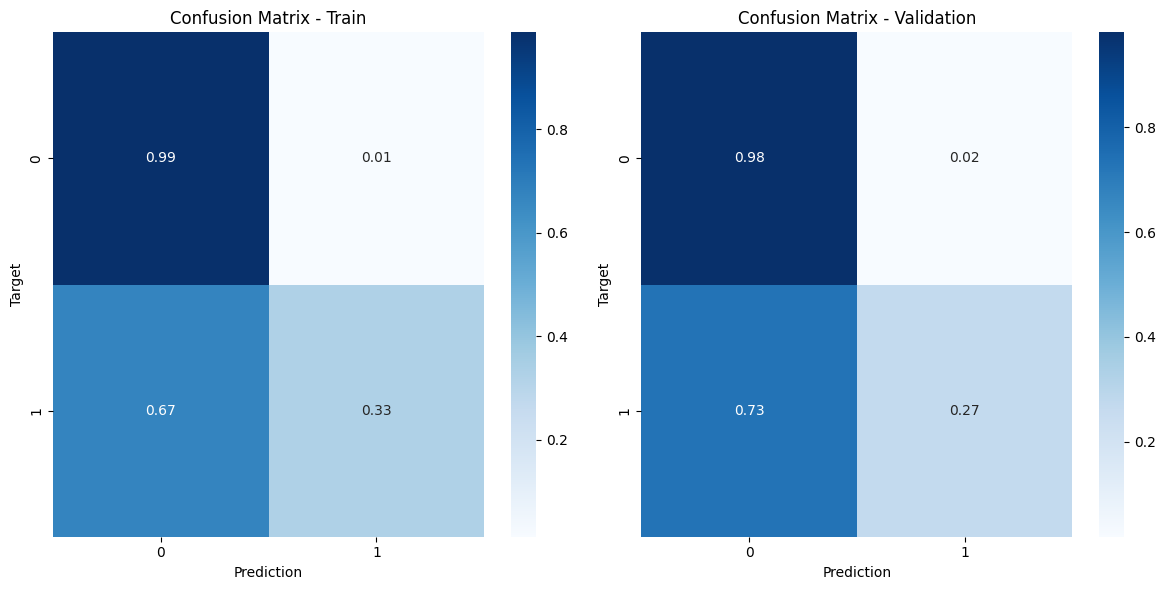

AUROC for Train dataset: 0.8785
AUROC for Validation dataset: 0.8115


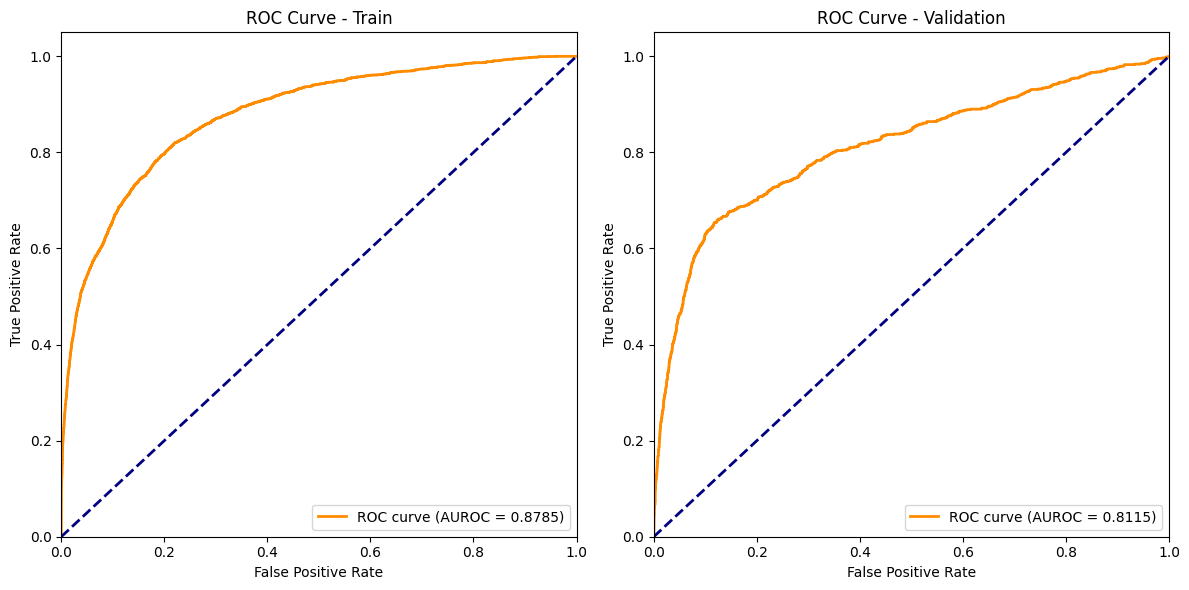

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4591 │           0.3786 │
│ roc_auc  │      0.8785 │           0.8115 │
└──────────┴─────────────┴──────────────────┘

In [49]:
evaluate_model(lgb_model_r, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 2% помилково передбачено укладання депозиту для тих, хто не уклав.
- 72.2% (на тренуванні) та 74.0% (на валідації) передбачено як "Ні", коли насправді "Так".
- Бачимо, зі значення AUROC відмінна стабільність, без значного перенавчання.
- F1-score трохи покращився у порівнянні з базовим LightGBM.
- Модель не демонструє сильного перенавчання, але все ще має проблеми з розпізнаванням позитивного класу.
- Гіперпараметричний тюнінг через RandomizedSearchCV трохи покращив F1-score і стабілізував AUROC.

In [50]:
model_comparator.update_model_comment(lgb_model_r,
                                      "Хороша модель. RandomizedSearchCV покращив AUROC та трохи підвищив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### LGBMModel with tuning hyperparameters via RandomizedSearchCV with resampling

In [51]:
lgb_model_r_rs = LGBMModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                        params=best_params_random_lgb).fit().predict()

[LightGBM] [Info] Number of positive: 14619, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 43857, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


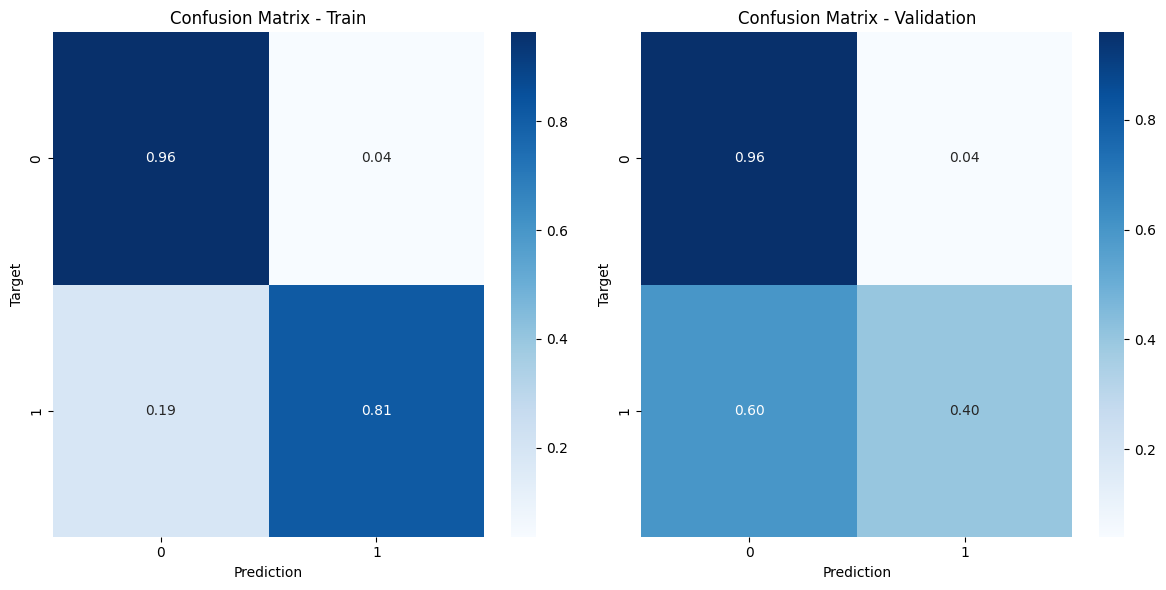

AUROC for Train dataset: 0.9534
AUROC for Validation dataset: 0.8020


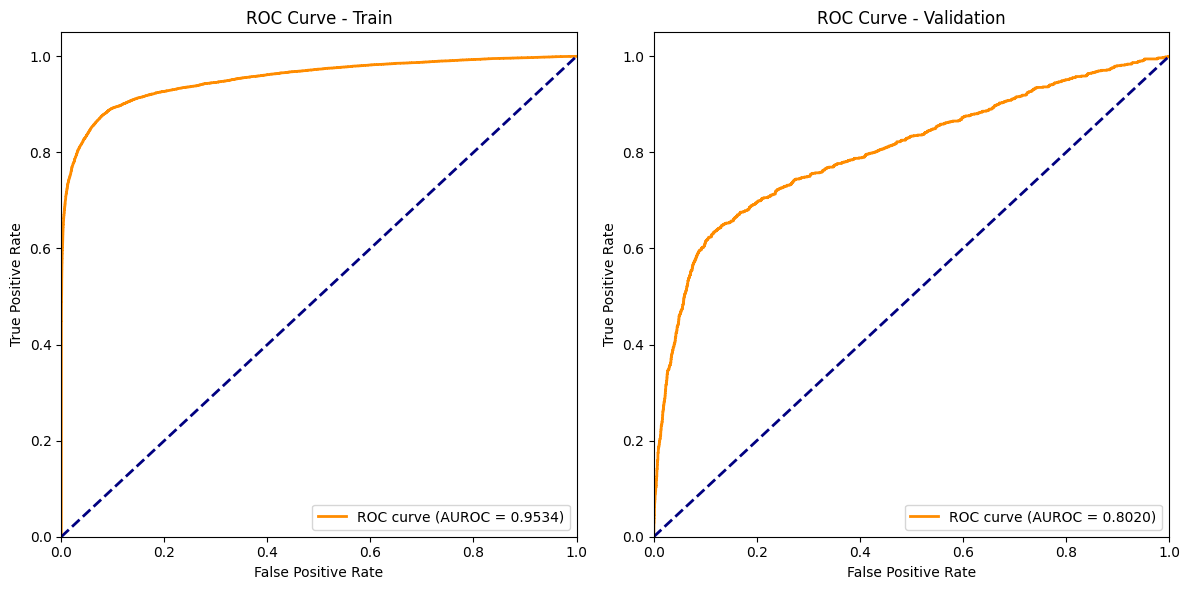

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8620 │           0.4675 │
│ roc_auc  │      0.9534 │           0.8020 │
└──────────┴─────────────┴──────────────────┘

In [52]:
evaluate_model(lgb_model_r_rs, "With RandomizedSearchCV tuning and resampling")

**Спостереження**:

- Модель добре передбачає негативні випадки.
- Бачимо по roc_auc, що модель має перенавчання. Значення на тренувальному наборі достатньо високе, але зменшується на валідації.
- Загалом F1-score трохи покращився у порівнянні з базовим LightGBM.
- F1-score значно падає на тренувальному наборі, що означає проблеми з передбаченнями, на нових даних.

In [53]:
model_comparator.update_model_comment(lgb_model_r_rs, "Хороша модель. Наявне перенавчання, можна спробувати покращити.")

#### LGBMModel with tuning hyperparameters via Hyperopt

In [54]:
lgb_space_h = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.5),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.05)
}

In [55]:
tuner_hyperopt_lgb = HyperoptTuner(LGBMClassifier, X_train, y_train, X_val, y_val, lgb_space_h)
best_params_hyperopt_lgb = tuner_hyperopt_lgb.tune(transform=False)

 85%|████████▌ | 17/20 [00:15<00:02,  1.09trial/s, best loss: -0.8170787831973205]


In [56]:
lgb_model_h = LGBMModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                        params=best_params_hyperopt_lgb).fit().predict()

AUROC for Train dataset: 0.8381
AUROC for Validation dataset: 0.8171


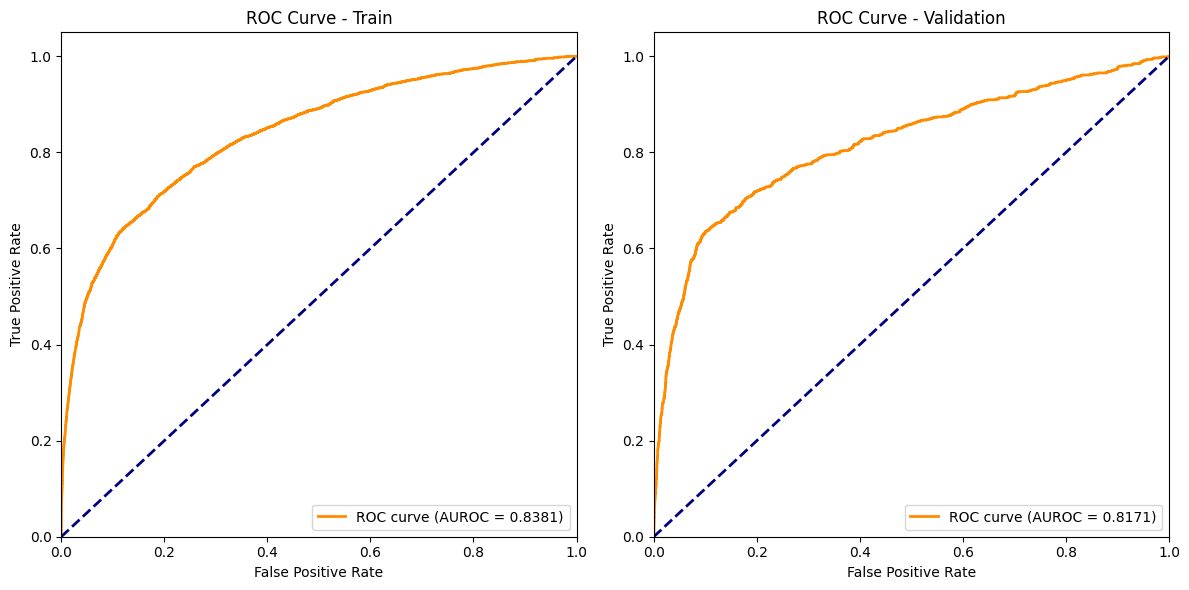

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4057 │           0.3712 │
│ roc_auc  │      0.8381 │           0.8171 │
└──────────┴─────────────┴──────────────────┘

In [57]:
evaluate_model(lgb_model_h, "With Hyperopt tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.7% (та 1.3% на тренуванні) помилково передбачено укладання депозиту для тих, хто не уклав.
- 68.7% (на тренуванні) та 72.9% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо, що є невеликий розрив між тренувальним та вваліджаційним наборами даних.
- F1-score покращився у порівнянні з RandomizedSearchCV, але незначно.
- Hyperopt дозволив досягти трохи кращої продуктивності без значного перенавчання.
- Модель добре розрізняє класи, але все ще має труднощі з точним передбаченням класу "Так".


In [58]:
model_comparator.update_model_comment(lgb_model_h,
                                      "Хороша модель. Hyperopt покращив AUROC та трохи підвищив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### LGBMModel with tuning hyperparameters via Hyperopt and resampling


In [59]:
lgb_model_h_rs = LGBMModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val, params=best_params_hyperopt_lgb).fit().predict()

AUROC for Train dataset: 0.9080
AUROC for Validation dataset: 0.7986


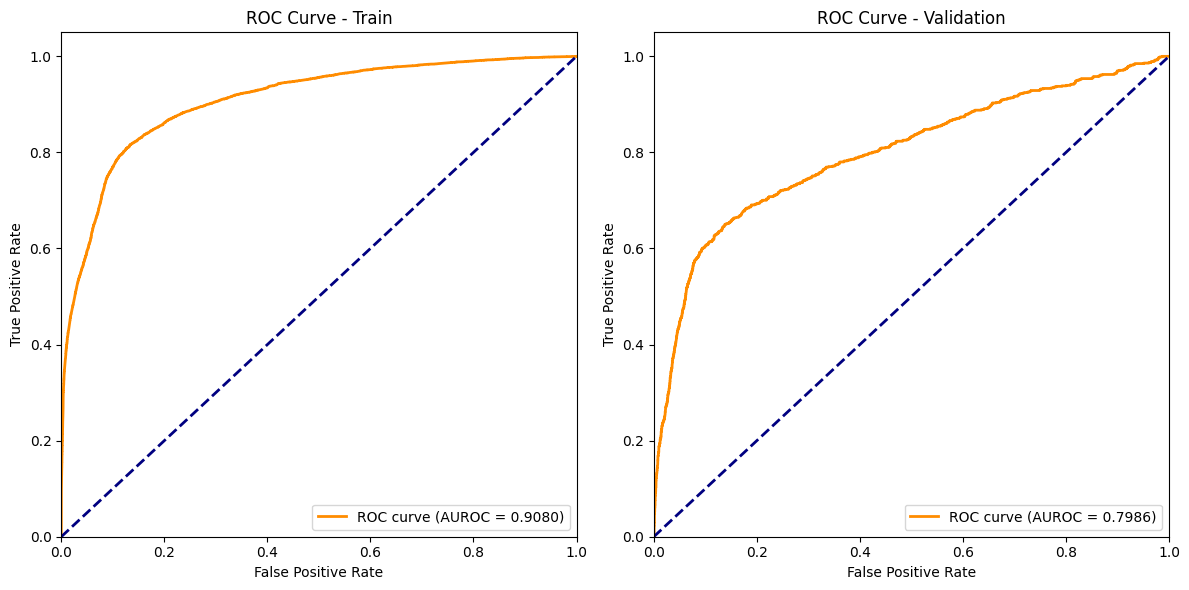

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7304 │           0.5011 │
│ roc_auc  │      0.9080 │           0.7986 │
└──────────┴─────────────┴──────────────────┘

In [60]:
evaluate_model(lgb_model_h_rs, "With Hyperopt tuning and resampling")

**Спостереження**:

- Модель добре передбачає негативні випадки: 94% реальних "Ні" правильно передбачено як "Ні".
- 6% помилково передбачено укладання депозиту для тих, хто не уклав.
- 30% (на тренуванні) та 53% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо, що є розрив між тренувальним та валіджаційним наборами даних, отже наявне перенавчання.
- Модель добре розрізняє класи, але все ще має труднощі з точним передбаченням класу "Так".

In [61]:
model_comparator.update_model_comment(lgb_model_h_rs, "Хороша модель. Наявне перенавчання, можна спробувати покращити якість моделі.")

## Аналіз моделей

Отже, натренувавши 24 моделі, можемо бачити, що для більшості моделей притаманне перенавчання, та відносно не високі значення F1_score.
Було проведено експерименти на даних з оверсамплінгом та без ресамплінгу. Підсумовуючи можемо сказати, що балансування вибиріки приводлило до покращення значень метрик, як на тренувальному так і на валідаційному наборах. Але дуже часто спостерігалось перенавчання при застосуванні ресамплінгу.

Основні аспекти, які розглядались при оцінці моделей:

- Якість класифікації (F1-score, AUROC):
    - Для оцінки кожної окремої моделі та формування коментаря до неї враховувалось значення F1-score, оскільки він показує баланс між precision (точністю) і recall (повнотою) для позитивного класу.
    - AUROC використано як загальний індикатор якості моделювання- дана метрика обрана як основна.

- Стійкість моделі до перенавчання:

    - Проаналізовано різницю між результатами на тренувальній (Train) та валідаційній (Validation) вибірках.
    - Для багатьох моделей спостерігається перенавчання, особливо при застосуванні оверсамплінгу.

- Вплив тюнингу та балансування класів:

    - Використання поліноміальних ознак трохи покращувало точність, але мало незначний вплив на загальну якість.
    - Ресемплінг суттєво покращував здатність розпізнавання позитивного класу, але часто приводив до перенавчання.
    - Тюнінг гіперпараметрів (RandomizedSearchCV, Hyperopt) у більшості випадків покращував узагальнюючу здатність моделі.

Подивимось на задагільні результати проведених експериментів

In [62]:
model_comparator.compare_models().head(25)

Model  \
0   LogisticRegressionModel   
1   LogisticRegressionModel   
2   LogisticRegressionModel   
3                  KNNModel   
4                  KNNModel   
5                  KNNModel   
6                  KNNModel   
7                  KNNModel   
8                  KNNModel   
9         DecisionTreeModel   
10        DecisionTreeModel   
11        DecisionTreeModel   
12        RandomForestModel   
13        RandomForestModel   
14                 XGBModel   
15                 XGBModel   
16                 XGBModel   
17                 XGBModel   
18                 XGBModel   
19                LGBMModel   
20                LGBMModel   
21                LGBMModel   
22                LGBMModel   
23                LGBMModel   

                                      Hyperparameters  roc_auc_T  roc_auc_V  \
0   {'C': 1.0, 'class_weight': None, 'dual': False...     0.7864     0.7993   
1   {'C': 1.0, 'class_weight': None, 'dual': False...     0.8163     0.7964   
2   {'C': 1.0, 'class_weight': None, 'dual': False...     0.8648     0.7898   
3   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.9510     0.7098   
4   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.9245     0.7332   
5   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.8877     0.7550   
6   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.9800     0.7058   
7   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.9661     0.7273   
8   {'algorithm': 'auto', 'leaf_size': 30, 'metric...     0.9414     0.7421   
9   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...     0.7854     0.7955   
10  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...     0.7853     0.7957   
11  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...     0.8046     0.7805   
12  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...     0.8379     0.8097   
13  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...     0.9999     0.7766   
14  {'objective': 'binary:logistic', 'base_score':...     0.8203     0.8147   
15  {'objective': 'binary:logistic', 'base_score':...     0.8213     0.8151   
16  {'objective': 'binary:logistic', 'base_score':...     0.8916     0.7973   
17  {'objective': 'binary:logistic', 'base_score':...     0.8341     0.8166   
18  {'objective': 'binary:logistic', 'base_score':...     0.9095     0.7985   
19  {'boosting_type': 'gbdt', 'class_weight': None...     0.8943     0.8129   
20  {'boosting_type': 'gbdt', 'class_weight': None...     0.8785     0.8115   
21  {'boosting_type': 'gbdt', 'class_weight': None...     0.9534     0.8020   
22  {'boosting_type': 'gbdt', 'class_weight': None...     0.8381     0.8171   
23  {'boosting_type': 'gbdt', 'class_weight': None...     0.9080     0.7986   

                                            Notes  \
0                                 Baseline model.   
1                      Added polynomial features.   
2                           With data resampling.   
3                                         kNN k=3   
4                                         kNN k=5   
5                                        kNN k=10   
6                         kNN k=3 with resampling   
7                         kNN k=5 with resampling   
8                        kNN k=10 with resampling   
9                                  Baseline model   
10                        Added cross validation.   
11                               With resampling.   
12                                 Baseline model   
13                          With data resampling.   
14                                 Baseline model   
15                 With RandomizedSearchCV tuning   
16                 With RandomizedSearchCV tuning   
17                           With Hyperopt tuning   
18                           With Hyperopt tuning   
19                                Baseline model.   
20                 With RandomizedSearchCV tuning   
21  With RandomizedSearchCV tuning and resampling   
22                           With Hyperopt tuning  

**Спостереження**:

Найкраще себе показала модель XGBModel з тюнингом гіперпараметрів за допомогою RandomizedSearchCV


## Аналіз ознак XGBModel

Проглянемо найважливіші ознаки для моделі

In [63]:
feature_importance = xgb_model_r.model.feature_importances_
features = X_train.columns
df_importance = pd.DataFrame({"Feature": features, "Importance": feature_importance})
df_importance = df_importance.sort_values(by="Importance", ascending=False)
df_importance

Feature  Importance
11               nr.employed    0.563544
18      was_contacted_before    0.062751
47          poutcome_success    0.050366
7               emp.var.rate    0.049365
3                      month    0.033297
10                 euribor3m    0.014479
2                    contact    0.013067
15           default_unknown    0.012712
9              cons.conf.idx    0.012563
8             cons.price.idx    0.012015
45          poutcome_failure    0.011863
6                   previous    0.010797
26           job_blue-collar    0.009660
43                default_no    0.008820
22            total_contacts    0.008466
4                day_of_week    0.008328
30               job_retired    0.006953
0                        age    0.006757
5                   campaign    0.005669
13               job_unknown    0.005602
36          marital_divorced    0.005427
1                  education    0.005336
19   campaign_previous_ratio    0.005294
33               job_student    0.005182
38            marital_single    0.004987
24   campaign_to_total_ratio    0.004889
34            job_technician    0.004872
29            job_management    0.004705
31         job_self-employed    0.004644
39                housing_no    0.004484
16           housing_unknown    0.004472
35            job_unemployed    0.004437
41                   loan_no    0.004188
37           marital_married    0.004180
27          job_entrepreneur    0.004171
32              job_services    0.004104
42                  loan_yes    0.003774
20          second_half_year    0.003560
40               housing_yes    0.003559
25                job_admin.    0.003519
28             job_housemaid    0.003142
12         education_unknown    0.000000
14           marital_unknown    0.000000
23  was_previously_contacted    0.000000
21              weekday_call    0.000000
17              loan_unknown    0.000000
44               default_yes    0.000000
46      poutcome_nonexistent    0.000000

**Спостереження**:

1. Макроекономічні показники є найбільш важливими у моделі, що підтверджує вплив економічної ситуації на фінансові рішення клієнтів:
- `nr.employed` - найвпливовіша змінна, що відображає загальний рівень зайнятості.Отже маємо, що змінна є найсильнішим предиктором. Висока зайнятість означає стабільний дохід у населення, що збільшує шанси на відкриття депозиту.
- `emp.var.rate` - темпи зміни рівня зайнятості показує економічну стабільність або кризу. Якщо ситуація нестабільна, люди менш охоче розміщують депозити.
- `euribor3m` - процентна ставка безпосередньо впливає на привабливість депозитів.
- `cons.conf.idx` та `cons.price.idx` – індекс довіри споживачів і рівень цін мають значення, оскільки відображають рівень економічного оптимізму.


2. Вплив попереднього контакту:
- `was_contacted_before` - якщо клієнта раніше контактували, він має вищі шанси оформити депозит.
- `poutcome_success` – якщо клієнт успішно взаємодіяв із банком у минулому, то ймовірність відкриття депозиту зростає.
- `poutcome_failure` – невдача в попередніх кампаніях також важлива, що може свідчити про наполегливість клієнта чи банки у спробах продати послугу.
- `total_contacts` – чим більше разів клієнта контактують, тим вища ймовірність підписання договору.


3. Часові фактори:
- `month` – вплив місяця контакту є відчутним, що може свідчити про сезонність у фінансових рішеннях.
- `day_of_week` - має не такий сильний вплив.
- `second_half_year` - можемо сказати, що корелює з підписанням договору.

4. Демографічні характеристики:
- `age` – вік є важливим фактором, але його вплив менший за макроекономічні та контактні характеристики.
- `education` – освіта також відіграє роль, але не є визначальною.
- `marital_status` – сімейний статус майже не впливає.
- `education_unknown`, `marital_unknown`, `housing_unknown`, `loan_unknown` – Відсутність даних не дає предиктивної цінності.

5. Фінансові характеристики клієнта:
- `loan_yes` – клієнти з позиками менш схильні до відкриття депозиту, оскільки мають фінансові зобов’язання.
- `housing_yes` - володіння житлом майже не впливає.

## Аналіз ознак з бібліотекою SHAP

Подивимося на кластеризований барплот, щоб продивитись які групи ознак мають подібний вплив на модель, та які ознаки найбільш важливі.

In [65]:
explainer = shap.TreeExplainer(xgb_model_r.model)
shap_values_ = explainer(X_val)
shap_values = explainer.shap_values(X_val)

Подивимося на кластеризований барплот, щоб продивитись які групи ознак мають подібний вплив на модель, та які ознаки найбільш важливі.

49it [00:35,  1.19it/s]


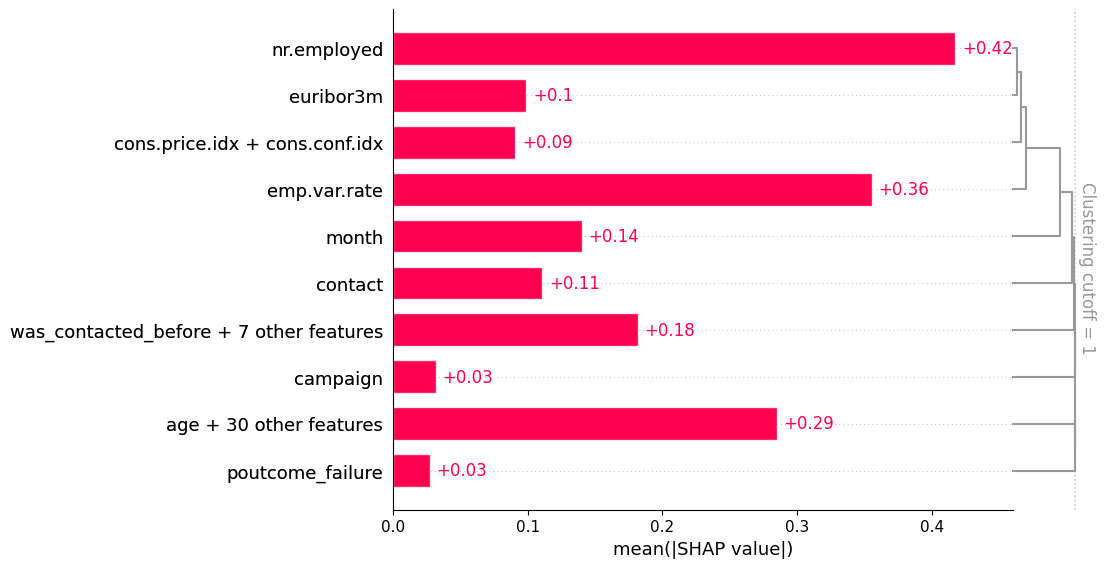

In [66]:
clust = shap.utils.hclust(X_val, y_val, linkage="complete")
shap.plots.bar(shap_values_, clustering=clust, clustering_cutoff=1)

**Спостереження**:

 - `nr.employed`- найважливіша ознака. Це логічно, оскільки рівень зайнятості в країні відображає загальну економічну стабільність, що впливає на бажання людей вкладати кошти.

 - `emp.var.rate` - темп зміни рівня зайнятості також суттєво впливає: зростання зайнятості підвищує ймовірність відкриття депозиту.

- `age + 30 other features` - велика група змінних, які окремо менш впливові, але разом дають певний ефект.

- `was_contacted_before + 7 other features` - попередній контакт з клієнтом разом із іншими змінними також є помітним фактором.

- `month` - також впливова ознака, вплив місяця може відображати сезонність у поведінці клієнтів.

- `contact` - тип контакту відіграє певну роль у рішенні клієнта.

- `cons.price.idx + cons.conf.idx` - індекс споживчих цін та довіри відображає загальні фінансові очікування споживачів.



In [67]:
sample_size = min(500, X_val.shape[0])
subset_indices = np.random.choice(X_val.shape[0], sample_size, replace=False)

shap_values_subset = shap_values[subset_indices]
X_val_subset = X_val.iloc[subset_indices]

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_subset, X_val_subset)

In [69]:
shap.dependence_plot('euribor3m', shap_values, X_val, interaction_index=None)

**Спостереження**:

- Бачимо два окремих кластера значень euribor3m.
- Для низьких значень euribor3m присутні різні SHAP-значення, в тому числі і  високі. Для сердніх,  SHAP-значення відсутні, отже можемо припускати нульовий вплив. Для вищих значень знову спостерігаєтся ріст SHAP-значеннь.
- При низькому euribor3m (~-1.5) SHAP позитивний: низька ставка - більше депозитів.
- При середньому euribor3m (~0.0) SHAP майже 0, отже, модель не вважає цей рівень значущим.
- При високому euribor3m (~0.5) - SHAP знову зростає, отже і ймовірність депозитів. Такий ефект може залежати від від інших макроекономічних показників, зокрема nr.employed і cons.price.idx.

In [70]:
shap.dependence_plot("nr.employed", shap_values, X_val)

**Спостереження**:

`nr.employed` - найважливіша змінна.

- Бачимо, що при низьких значеннях `nr.employed` маємо високі SHAP-значення, що означає, що низький рівень зайнятості підвищує ймовірність підписання депозиту.
Можемо припустити, що у кризові періоди люди більше відкладають кошти на депозити.

- При середніх значеннях `nr.employed` коливається навколо 0, тобто нейтральний вплив. Це означає, що у цьому діапазоні рівень зайнятості майже не впливає на ймовірність депозиту.

- Низькі значення `nr.employed` значення SHAP дуже низьке або навіть негативне, що означає, що високий рівень зайнятості знижує ймовірність підписання депозиту.

- Червоні точки (contact=1) та сині точки (contact=0) розподілені рівномірно → це означає, що тип контакту (мобільний/стаціонарний) не сильно впливає на цю залежність.

Отже, зростання `nr.employed` впливаєнегативно на підписання депозитів.
Низьке безробіття (високий `nr.employed`) - менше депозитів.
Високе безробіття (низький `nr.employed`) - більше депозитів.


**Припущення**:
- Можливо, ринок праці стабільний, і люди не відчувають необхідності у великих заощадженнях. Так, якщо безробіття високе, люди можуть частіше вкладати гроші у депозити для "фінансової подушки".


In [71]:
shap.dependence_plot("emp.var.rate", shap_values, X_val)

**Спостереження**:

- Бачимо, що  при негативних значеннях `emp.var.rate` - позитивний SHAP. Коли темп зміни зайнятості падає - економіка стає нестабільною. Тож SHAP значення стають позитивними - модель прогнозує вищу ймовірність депозиту.

- При нульових значеннях - SHAP - також приблизно нульові, отже такі значення не впливають на депозити.

- Позитивні значення emp.var.rate - негативні SHAP значення. Коли економіка зростає і рівень зайнятості збільшується, SHAP значення від’ємні- модель прогнозує меншу ймовірність депозиту.

- Червоні точки (високий total_contacts) та сині точки (низький total_contacts) розподілені без явної закономірності. Це означає, що кількість контактів клієнта не впливає на взаємозв'язок emp.var.rate та рішення про депозит.


**Припущення**:
- Коли економіка зростає і рівень зайнятості збільшується, SHAP значення від’ємні- модель прогнозує меншу ймовірність депозиту. Люди в періоди зростання економіки можуть менше вкладати у депозити і більше витрачати або інвестувати.

In [72]:
shap.dependence_plot("month", shap_values, X_val)

**Спостереження**:

- Бачмо високий влив початку року - найвищі значення SHAP спостерегаються з початку року до квітня. Це означає, що в ці місяці ймовірність підписання депозиту була найвищою. Логічно припустити, що у весняний період банки активніше проводили маркетингові кампанії, або клієнти були більш схильні до вкладень.

- Починаючи з травня (month = 5) і до листопада (month = 11), SHAP значення близькі до нуля або навіть негативні. Це свідчить про сезонне зниження ймовірності депозитів – можливо, люди витрачають гроші на відпустки або менш схильні до інвестування у літньо-осінній період.

- Листопад (month = 11) показує зростання SHAP значень. У листопаді SHAP значення дещо зростає, що може вказувати на активізацію клієнтів перед закінченням року або маркетингові зусилля банків у передсвятковий період.

- euribor3m впливає на зв’язок місяця та підписання депозиту. Сині точки (низькі процентні ставки euribor3m) - вищі SHAP значення. Червоні точки (високі процентні ставки) - низькі або негативні SHAP значення. Низькі процентні ставки роблять депозити більш привабливими для клієнтів, тому SHAP значення для таких періодів вищі.



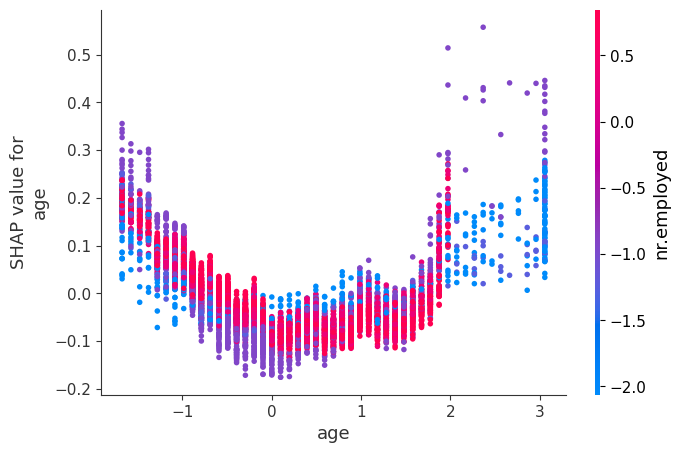

In [73]:
shap.dependence_plot("age", shap_values, X_val)

**Спостереження**:

- Бачимо U-подібну форма впливу віку.
- Молоді та старші клієнти мають позитивні SHAP значення - отже, вища ймовірність підписання депозиту.
- Середній вік (~0 на осі X) має негативні SHAP значення - тож, знижується ймовірність підписання депозиту.
- Зі зростанням віку, бачимо ріст SHAP значеннь.

- `nr.employed`:
  - Сині точки (низька зайнятість) - мають вищі SHAP значення, що означає більшу ймовірність депозиту.
  - Червоні точки (висока зайнятість) - зменшують SHAP, що вказує на те, що при хорошій зайнятості люди менше оформлюють депозити.

- Значення віку 2+ (ймовірно приблизно 50+ років, адже виконували скейлинг) – зростає ймовірність депозиту: у цій групі клієнтів SHAP значення різко збільшується. Це може вказувати на пенсіонерів або людей перед пенсією, які накопичують гроші

**Припущення**:

- Молоді люди, ймовірно, ще не мають великих фінансових зобов’язань і готові вкладати гроші.
Старші люди, які накопичили заощадження, теж схильні відкривати депозити.
Люди середнього віку, які активно працюють і мають кредити, менш схильні до депозитів.

- Загалом картина по `nr.employed` узгоджується з економічною логікою, яку вже спостерігали при аналізі минулих залежностей: при низькій зайнятості люди більше схильні зберігати гроші на депозитах.

- Фактор зайнятості `nr.employed` змінює ефект віку: коли безробіття високе, люди частіше відкладають гроші.

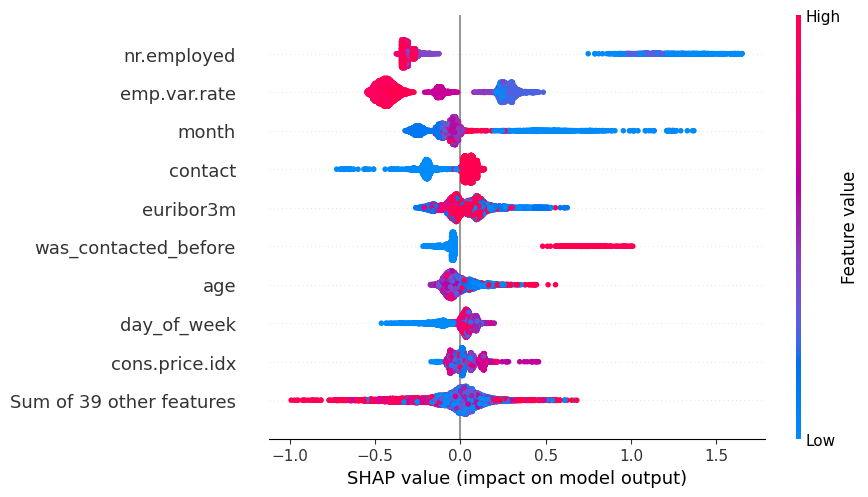

In [74]:
explanation = explainer(X_val)
shap.plots.beeswarm(explanation)

## Аналіз помилок

In [75]:
analyzer = ModelErrorAnalyzer(model=xgb_model_r, X_val=X_val, y_val=y_val)

In [76]:
fp, fn = analyzer.get_misclassified_samples()
display(fp.head(5)), display(fn.head(5))

age  education  contact  month  day_of_week  campaign  previous  \
40076  3.059089        5.0        1      7            4  0.000244 -0.376437   
30307 -0.293032        4.0        1      4            4 -0.932178  1.922654   
40040 -0.983174        6.0        1      7            2  0.000244  1.922654   
39572 -0.983174        6.0        1      5            2 -0.932178  1.922654   
39743  0.890070        6.0        1      5            4 -0.932178  1.922654   

       emp.var.rate  cons.price.idx  cons.conf.idx  ...  loan_no  loan_yes  \
40076     -1.133161        1.103451       0.043601  ...      1.0       0.0   
30307     -1.196805       -0.864782      -1.430459  ...      1.0       0.0   
40040     -1.133161        1.103451       0.043601  ...      1.0       0.0   
39572     -1.196805        0.518161       0.108634  ...      1.0       0.0   
39743     -1.196805        0.518161       0.108634  ...      1.0       0.0   

       default_no  default_yes  poutcome_failure  poutcome_nonexistent  \
40076         0.0          0.0               0.0                   1.0   
30307         1.0          0.0               0.0                   0.0   
40040         1.0          0.0               0.0                   0.0   
39572         1.0          0.0               0.0                   0.0   
39743         1.0          0.0               1.0                   0.0   

       poutcome_success  y_real  y_pred  y_pred_proba  
40076               0.0       0       1      0.529878  
30307               1.0       0       1      0.546450  
40040               1.0       0       1      0.845473  
39572               1.0       0       1      0.836753  
39743               0.0       0       1      0.543588  

[5 rows x 51 columns]

age  education  contact  month  day_of_week  campaign  previous  \
38884  2.763314        4.0        1     11            1  0.000244  1.922654   
28008 -0.983174        6.0        1      4            4  0.000244 -0.376437   
41119 -0.391623        2.0        1     11            2 -0.932178 -0.376437   
16326 -0.194440        4.0        1      7            2  2.255795 -0.376437   
26933 -0.588807        6.0        1     11            4  0.000244  1.922654   

       emp.var.rate  cons.price.idx  cons.conf.idx  ...  loan_no  loan_yes  \
38884     -2.215107       -1.600279       2.254692  ...      1.0       0.0   
28008     -1.196805       -0.864782      -1.430459  ...      0.0       1.0   
41119     -0.751297        2.056490      -1.950716  ...      1.0       0.0   
16326      0.839800        0.590675      -0.476655  ...      1.0       0.0   
26933     -0.114858       -0.648967      -0.324914  ...      1.0       0.0   

       default_no  default_yes  poutcome_failure  poutcome_nonexistent  \
38884         1.0          0.0               1.0                   0.0   
28008         1.0          0.0               0.0                   1.0   
41119         1.0          0.0               0.0                   1.0   
16326         1.0          0.0               0.0                   1.0   
26933         1.0          0.0               1.0                   0.0   

       poutcome_success  y_real  y_pred  y_pred_proba  
38884               0.0       1       0      0.362040  
28008               0.0       1       0      0.239512  
41119               0.0       1       0      0.462464  
16326               0.0       1       0      0.039639  
26933               0.0       1       0      0.047323  

[5 rows x 51 columns]

(None, None)

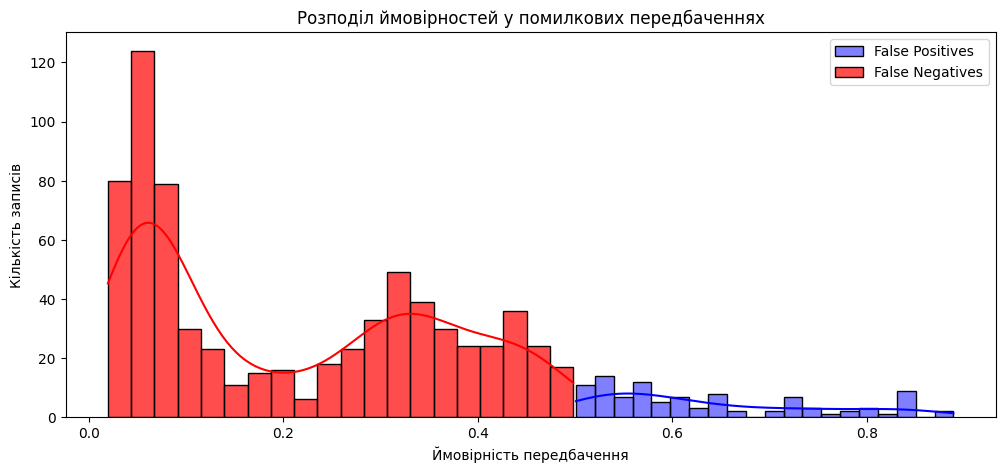

In [77]:
analyzer.visualize_misclassified_samples()

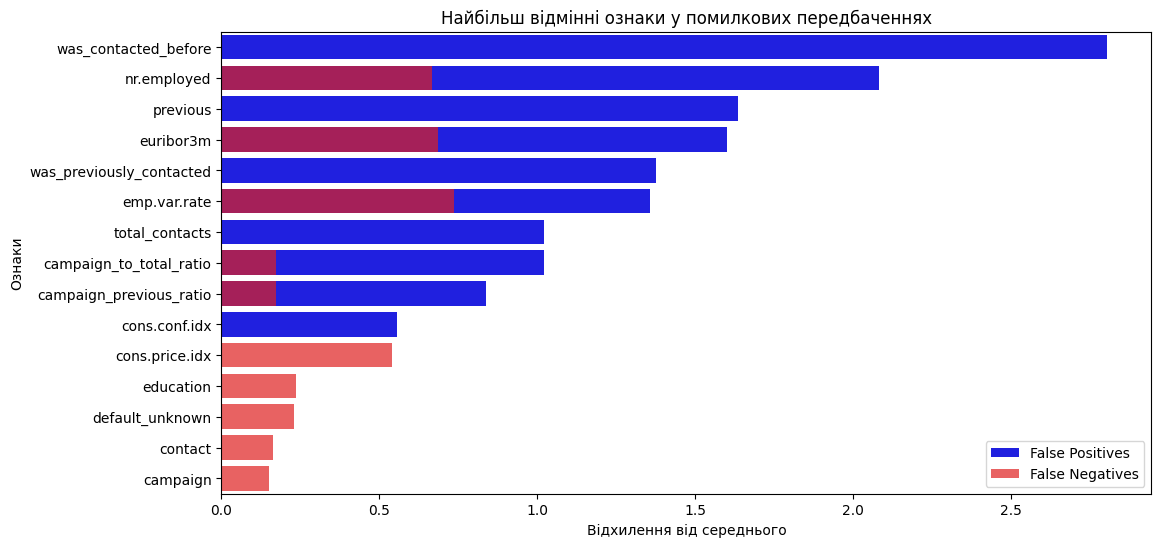

In [78]:
analyzer.analyze_top_features(top_n=10)

## Висновок

Можемо зробити припущення:

- Залежність від макроекономіки означає, що банк може прогнозувати успіх депозитної кампанії ще до її початку. Банку варто активніше рекламувати
депозити у періоди економічного зростання.
- Попередній досвід взаємодії з банком (як позитивний, так і негативний) має значний вплив.

- Цільова аудиторія може включати різні вікові групи та рівні освіти – немає явного обмеження.Банк не повинен занадто сильно фокусуватися на демографії – вона має менший вплив, ніж макроекономіка чи маркетинг.

- Є сильний сезонний ефект – певні місяці сприяють більшій кількості депозитів Потрібно протестувати різні періоди кампаній, щоб знайти оптимальний момент. Телефонувати клієнтам у конкретний день тижня – неважливо, але варто тестувати вплив місяця.

- Клієнти з кредитами не уникають депозитів, але їхній інтерес менший.

## Покращення:

- В ході аналізу впливу змінних, виявилось, що поведінка впливу euribor3m - є достатньо цікавою, має місце корреляція з іншими змінними макроекономічного характеру. Отже для покращення моделі варто врахувати цей факт.

-